## SEIRS Model

**Problem description**:

The SEIRS model describes the spread of a disease in a population fixed to $N$ individuals over time $t$. Furthermore, the model divides the population into four categories, called "S", "E", "I", and "R". The extra "S" at the end usually means we include the loss of immunity.
- "S" consists of individuals who are susceptible to the disease being modeled.
- "E" consists of individuals who are exposed to the disease. Diseases (like COVID-19) often have an incubation period or a latency period and this category accommodates it. (The SIR model does not have this category.)
- "I" consists of individuals infected with the disease and are capable of infecting others.
- "R" consists of individuals who can be removed from the system, e.g., because they have gained immunity to the disease, or because they have succumbed to the disease.

The SEIR model, like many other epidemiological models depends on particular parameters, which are the following :
 - $\beta>0$ The rate of contraction of the disease (transmission parameter)
 - $ \sigma >0$ The incubation rate i.e. the rate at which exposed hosts become infected
 - $\gamma>0$ : The mean recovery rate
 - $\xi>0$ : The loss of immunity rate. 
 
Individual $S$ becomes infected after positive contact with an $I$ individual. However, he develops immunity to the disease : he leaves $I$ category at a $\gamma$ cure rate. However with a rate $\xi$, they may lose immunity to the disease and rejoin the susceptible population $S$.

**Model Assumptions**

- Model is deterministic
- On average, an individual $S$ in the population encounters $\beta$ individuals per unit time.
- The rate of infected individuals leaving category $I$ is $\gamma I$ per unit time (once an individual has been infected, he develops immunity to the disease).
- The population size $N=S+E+I+R$ is constant.
- Note constant average number of contacts $\beta$ is a strong and constraining assumption : it cannot be applied to all diseases.

This is the system of equations of the model :

The total population $N$ in the system (the sum of individuals in all categories) is likely to be quite large. Instead of working with such large numbers, let us divide each side of each equation by $\mathbf{N}$ and work instead with the proportions
$$
s=\frac{S}{N}, \quad e=\frac{E}{N}, \quad i=\frac{I}{N}, \quad r=\frac{R}{N} .
$$
The equivalent ODE system to be solved for the unknown functions $s(t), e(t), i(t)$, and $r(t)$, has now become
$$
\begin{aligned}
& \frac{d s}{d t}=-\beta i s  + \xi r\\
& \frac{d e}{d t}=\beta i s-\sigma e \\
& \frac{d i}{d t}=\sigma e-\gamma i \\
& \frac{d r}{d t}=\gamma i - \xi r
\end{aligned}
$$
When supplemented with some initial conditions, say
$$
s(0)=0.99, \quad e(0)=0.01, \quad i(0)=0, \quad r(0)=0
$$
This is the formulation of the Initial Value Probelm we wish to solve. Note that the above initial conditions correspond to a starting scenario where just $1 \%$ of the population is exposed.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pydci.examples import seirs
import importlib
from pydci.log import enable_log, disable_log
from pydci.utils import get_l2_errs, set_seed

importlib.reload(seirs)




SEIRS_PARAM_MINS = 4*[0]
SEIRS_STATE_MINS = 1e-10
SEIRS_STATE_MAXS = 1

# For periodic behavior
R_0 = 3

# Sample every week
SEIRS_SAMPLE_TS = 1

# Populations are all from 0-1 -> Fraction of population
SEIRS_NOISE = 0.001

# Parameters from bjornstad2020seirs paper
SEIRS_P1 = [
    R_0 / 14.0,  # beta transmission rate - R_0 / gamma -> R_0 > 0 for periodic behavior
    1.0 / 7.0,  # sigma incubation rate i.e. rate at which exposed hosts become infected - 1 week
    1.0 / 14.0,  # gamma  mean recovery rate - 2 weeks
    1.0 / 365.0,  # xi - loss off imunity rate - 1 year
]

# (1) Policy Lockdown 1 month in: => Slower Transmission Rate(beta) - Time 75
SEIRS_P2 = [
    0.5 * R_0 / 14.0,  # transmission rate halved
    1.0 / 7.0,  # sigm
    1.0 / 14.0,
    1.0 / 365.0,
]
# (2) Virus Mutation 1 year in: => Faster Incubation Rate (sigma) - Time 150
SEIRS_P3 = [
    1.2 * R_0 / 14.0,  # transmission rate increased -> Faster transmitting virus
    1.0 / 3.5,   # Incubation rate halved -> Exposed hosts become infected quicker
    1.0 / 14.0,
    1.0 / 365.0,
]

SEIRS_X0 = [
    0.98,  # susceptible
    0.010,  # exposed
    0.010,  # infected
    0,  # recovered
]

# enable_log(level='DEBUG')
n_samples = 1000
total_time = 1*365.25
param_shifts = {0: SEIRS_P1, 25: SEIRS_P2, 150: SEIRS_P3}

## Problem Set-Up

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

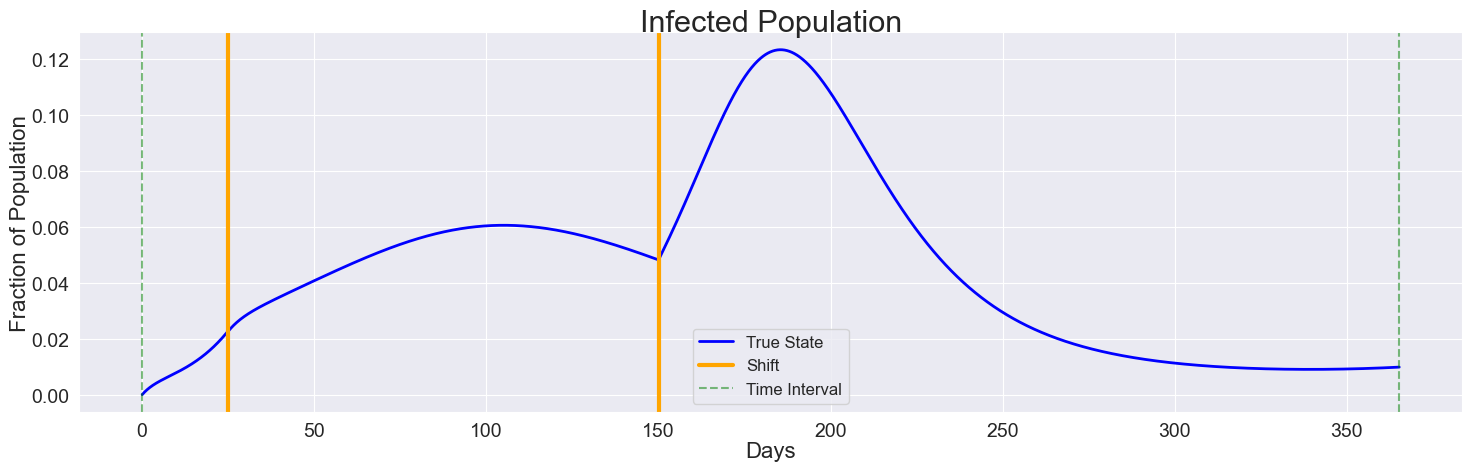

In [2]:
full_sr = seirs.SEIRSModel(lam_true=SEIRS_P1,
                      param_shifts=param_shifts,
                      measurement_noise=SEIRS_NOISE,
                      sample_ts=SEIRS_SAMPLE_TS,
                      state_mins=SEIRS_STATE_MINS,
                      state_maxs=SEIRS_STATE_MAXS)
# pi_in, samples = full_sr.get_uniform_initial_samples(num_samples=1, scale=0.1)
res = full_sr.get_data(total_time)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
full_sr.plot_infected(plot_samples=False, plot_measurements=False, ax=ax)

# Iterations - Fixed weekly chunks of data

- If problem has not been initialized (no self.probs[] array), then the problem
is initialized with a uniform distribution over the parameter space around the
true value, with a scale of `diff` controlling the size of the uniform distribution
around the true value we search for, and hence the problem difficulty.
- Solve inverse problem for `num_its` consuming `time_step` data at each iteration.
- At each iteration, a set of possible sovle parameters will be searched for, varying:
    - number of PCA components, 
    - data points.
    - number of splits to use on data splits.
- The best solution will be determined by the `best_method` argument.

In [3]:
# disable_log()
enable_log(level='DEBUG', file='test.log')
set_seed(2023)
sr = seirs.SEIRSModel(lam_true=SEIRS_P1,
                      param_shifts=param_shifts,
                      measurement_noise=SEIRS_NOISE,
                      sample_ts=SEIRS_SAMPLE_TS,
                      state_mins=SEIRS_STATE_MINS,
                      state_maxs=SEIRS_STATE_MAXS)

sr.online_iterative(
    num_its=52,
    num_samples=10000,
    time_step=7,
    comb_args={
        'max_nc': 2,
        'exp_thresh': 0.5,
        'data_chunk_size': 7,
        'all_data': True,
    },
    search_args={
        'exp_thresh': 0.1,
        'best_method': 'max_kl',
    },
    diff=1.0,
    kl_thresh=3.0,
)

Solving for different combinations |████████████████████████████████████████| 2/
Solving for different combinations |████████████████████████████████████████| 2/|                                        | ▂▄
Solving for different combinations |████████████████████████████████████████| 2/
Solving for different combinations |████████████████████████████████████████| 2/
Solving for different combinations |████████████████████████████████████████| 2/
Solving for different combinations |████████████████████████████████████████| 2/|████████▉           | ▃▁▃ 4442/10000 [44%] in 1s (~1s
Solving for different combinations |████████████████████████████████████████| 2/
Solving for different combinations |████████████████████████████████████████| 2/
Solving for different combinations |████████████████████████████████████████| 2/
Solving for different combinations |████████████████████████████████████████| 2/
Solving for different combinations |████████████████████████████████████████| 2/
Solving fo

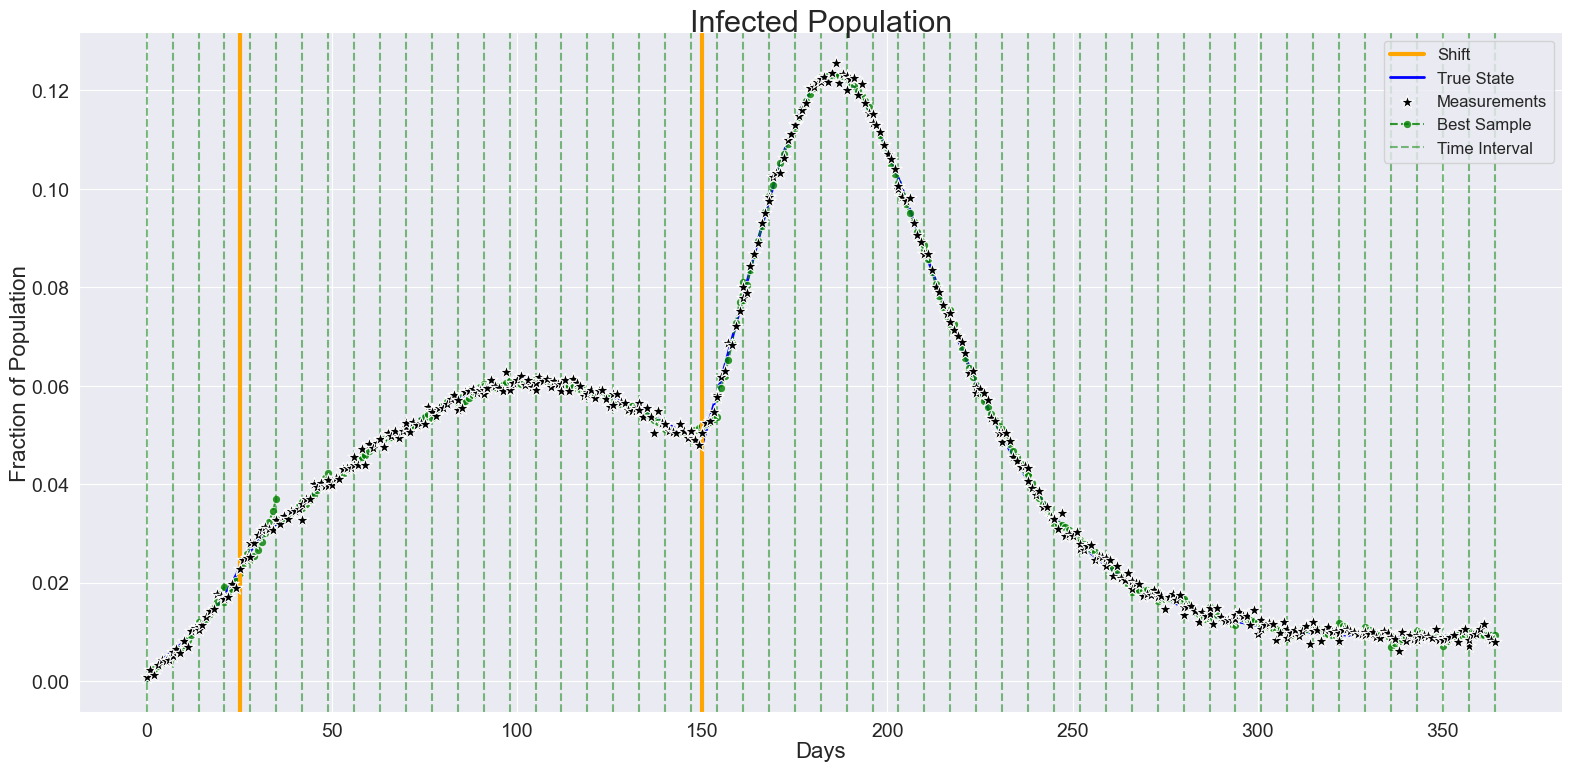

In [4]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
ax = sr.plot_infected(plot_samples=True, n_samples=0, ax=ax)
# ax.set_ylim([0.03,ax.get_ylim()[1]])

## First Shift - "Flattening the Curve"

(0.0, 70.0)

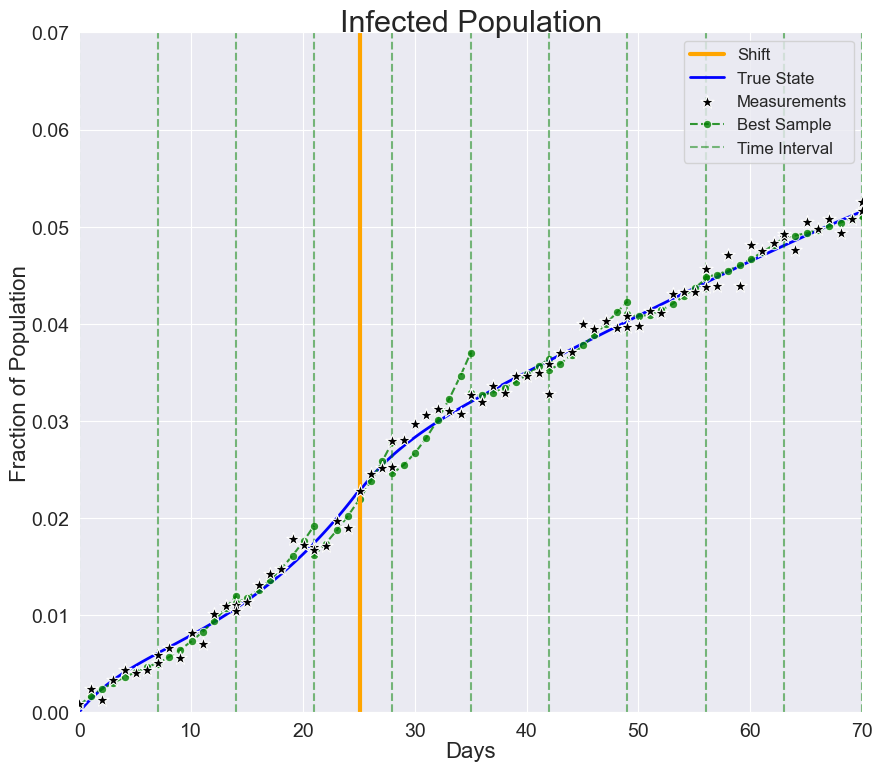

In [5]:
ax = sr.plot_infected(plot_samples=True, n_samples=0)
ax.set_ylim([0.0, 0.07])
ax.set_xlim([0, 70])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

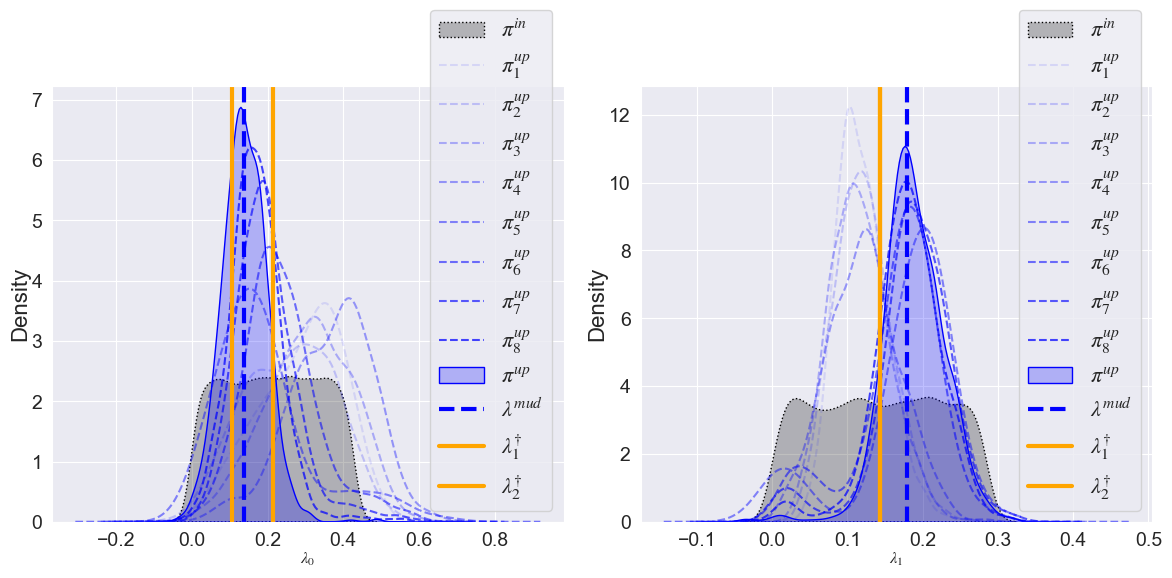

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sr.plot_param_density(sr.probs, param_idx=0, idxs=range(0, 10), lam_true=[(1, SEIRS_P1), (2, SEIRS_P2)], ax=ax[0])
sr.plot_param_density(sr.probs, param_idx=1, idxs=range(0, 10), lam_true=[(1, SEIRS_P1), (2, SEIRS_P2)], ax=ax[1])

## Second Shift - Mutation and Second Wave

(120.0, 180.0)

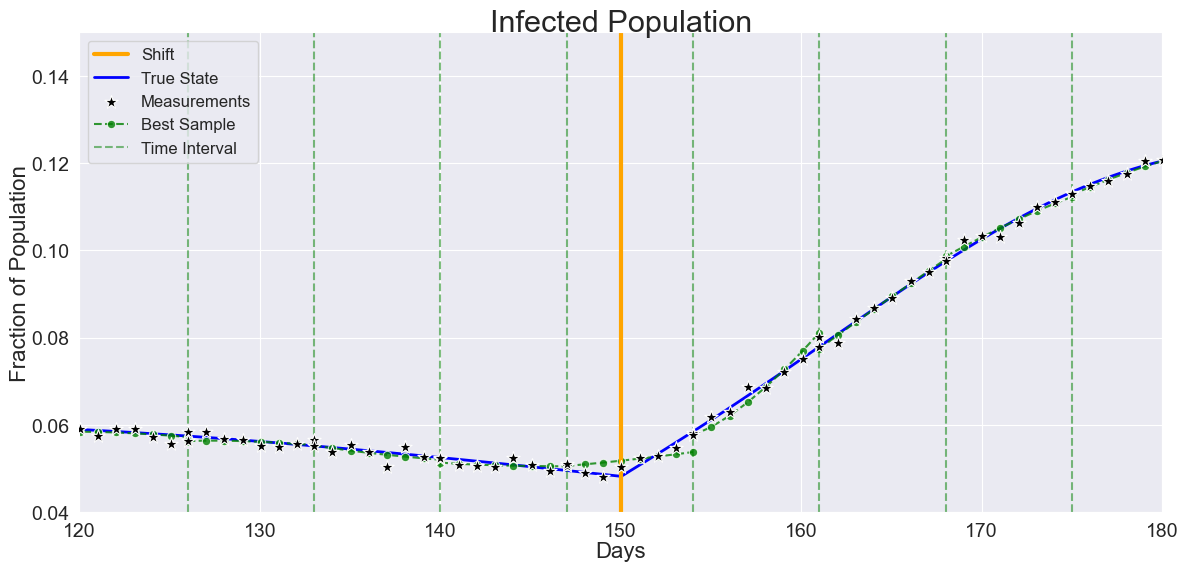

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = sr.plot_infected(plot_samples=True, n_samples=0, ax=ax)
ax.set_ylim([0.04, 0.15])
ax.set_xlim([120, 180])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

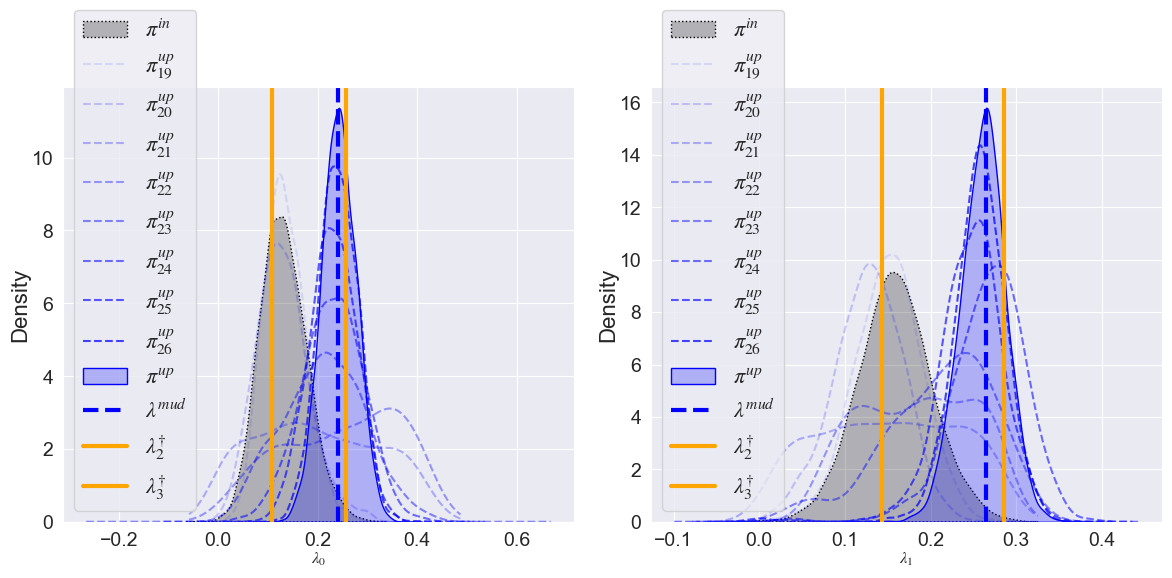

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sr.plot_param_density(sr.probs, param_idx=0, idxs=range(18, 28, 1), lam_true=[(2, SEIRS_P2), (3, SEIRS_P3)], ax=ax[0])
sr.plot_param_density(sr.probs, param_idx=1, idxs=range(18, 28, 1), lam_true=[(2, SEIRS_P2), (3, SEIRS_P3)], ax=ax[1])

# Adaptive Online Iterative

In [17]:
total_time = 10*7 # 1*365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(lam_true=SEIRS_P1,
                      param_shifts=param_shifts,
                      measurement_noise=SEIRS_NOISE,
                      sample_ts=SEIRS_SAMPLE_TS,
                      state_mins=SEIRS_STATE_MINS,
                      state_maxs=SEIRS_STATE_MAXS)

sgs, probs = sr.adaptive_online_iterative(
    np.arange(0, data_chunk_size*n_chunks+ 1, data_chunk_size),
    diff=1.0,
    num_samples=1000,
    nc=1,
    resample_thresh=0.2,
    shift_thresh=0.5,
    min_eff_sample_size=0.8,
    weights=None,
)

Solving model sample set: |█████▌              | ▂▄▆ 276/1000 [28%] in 0s (~0s, 

## Weekly chunks, full year

In [29]:
total_time = 1*365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(lam_true=SEIRS_P1,
                      param_shifts=param_shifts,
                      measurement_noise=SEIRS_NOISE,
                      sample_ts=SEIRS_SAMPLE_TS,
                      state_mins=SEIRS_STATE_MINS,
                      state_maxs=SEIRS_STATE_MAXS)

sgs, probs = sr.adaptive_online_iterative(
    np.arange(0, data_chunk_size*n_chunks+ 1, data_chunk_size),
    diff=1.0,
    num_samples=1000,
    nc=1,
    resample_thresh=0.2,
    shift_thresh=0.5,
    min_eff_sample_size=0.8,
    weights=None,
    seed=21,
)

Solving model sample set: |▎                   | ▁▃▅ 15/1000 [2%] in 0s (~0s, 61

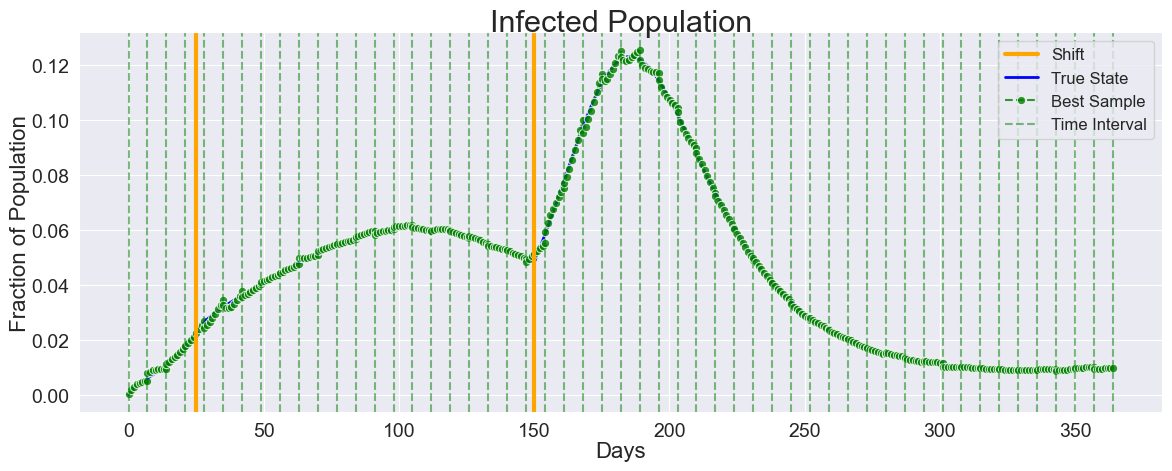

In [30]:
ax = sr.plot_infected(plot_measurements=False, plot_samples=True, n_samples=0, figsize=(12,5))

## First Shift - "Flattening of the Curve"

In [31]:
first_shift_end = 100

(-0.007089759073479672, 0.08)

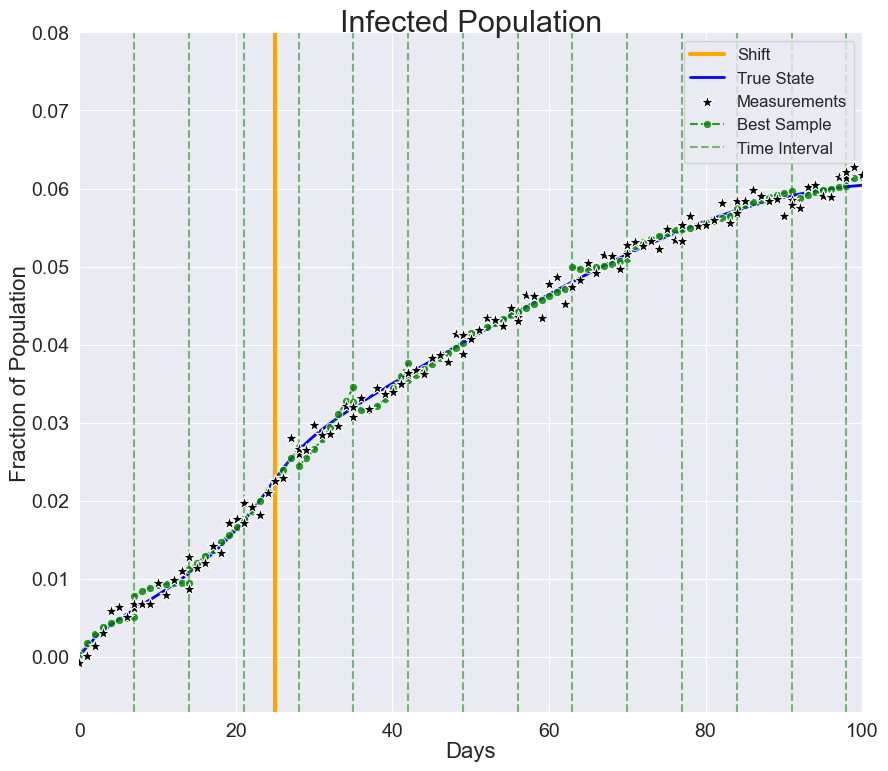

In [32]:
ax = sr.plot_infected(plot_samples=True, n_samples=0)
ax.set_xlim([0,first_shift_end])
ax.set_ylim([ax.get_ylim()[0],0.08])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

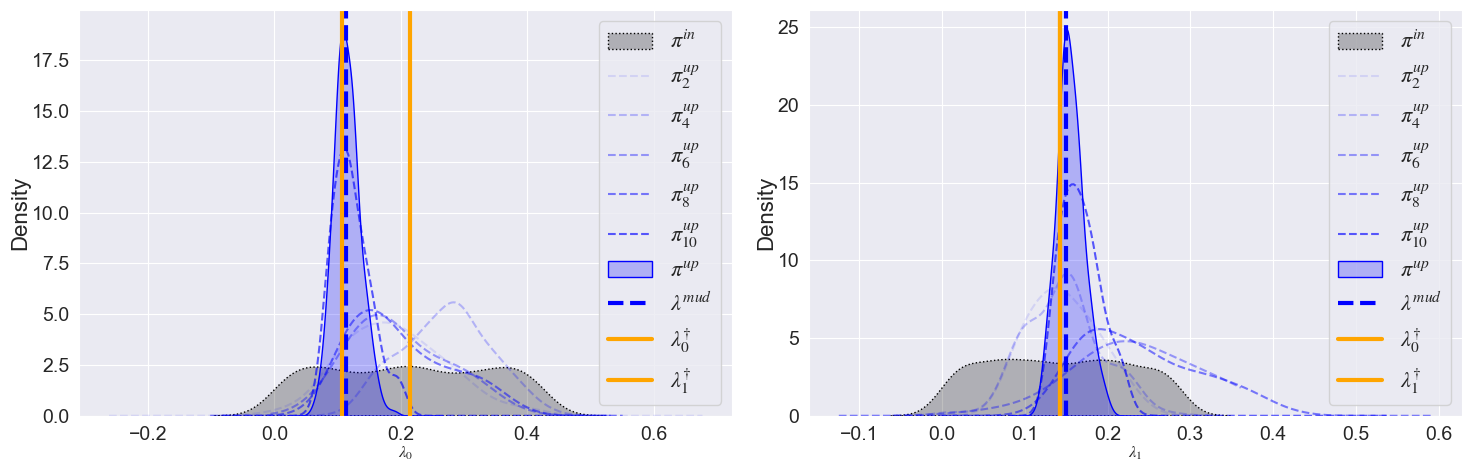

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sr.plot_param_density(probs, param_idx=0, idxs=np.arange(0, int(first_shift_end/7), 2), lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)], ax=axs[0])
sr.plot_param_density(probs, param_idx=1, idxs=np.arange(0, int(first_shift_end/7), 2), lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)], ax=axs[1])

## Second Shift - Mutation and "Second wave"

(120.0, 190.0)

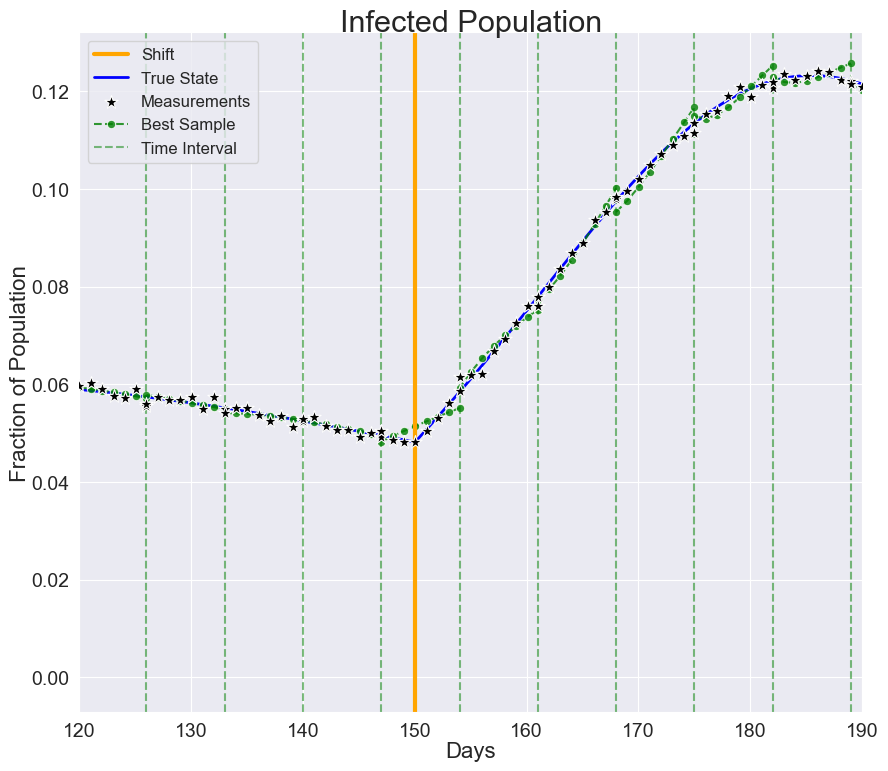

In [34]:
ax = sr.plot_infected(plot_samples=True, n_samples=0)
ax.set_xlim([120,190])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

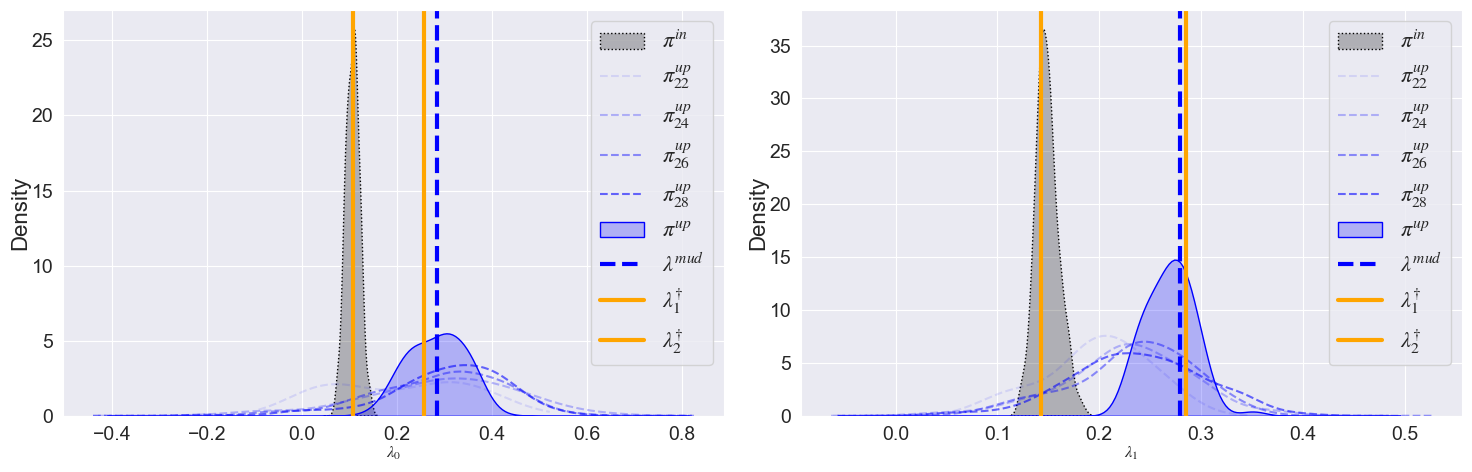

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sr.plot_param_density(probs, param_idx=0, idxs=np.arange(int(140/7), int(220/7), 2), lam_true=[(1, SEIRS_P2), (2, SEIRS_P3)], ax=axs[0])
sr.plot_param_density(probs, param_idx=1, idxs=np.arange(int(140/7), int(220/7), 2), lam_true=[(1, SEIRS_P2), (2, SEIRS_P3)], ax=axs[1])


# Online Iteartive - Algorithm Breakdowns

- Use fixed chunks of data, and a fixed set of "search" parameters per chunk of data
- Always re-sample between chunks of data.
- "Search" parameter determine the sets of solution parameters to use for each chunk when trying to solve the problem.
- Search params can vary the:

    1. \# of principal components
    2. \# of splits to use on the chunk of data, for doing offline iterative estimation.
    3. \# of total data points to use, i.e. whether to only use a fraction of the data chunk.


In [ ]:
total_time = 1*365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(lam_true=SEIRS_P1,
                      param_shifts=param_shifts,
                      measurement_noise=SEIRS_NOISE,
                      sample_ts=SEIRS_SAMPLE_TS,
                      state_mins=SEIRS_STATE_MINS,
                      state_maxs=SEIRS_STATE_MAXS)

sgs, probs = sr.adaptive_online_iterative(
    np.arange(0, data_chunk_size*n_chunks+ 1, data_chunk_size),
    diff=1.0,
    num_samples=1000,
    nc=1,
    resample_thresh=0.2,
    shift_thresh=0.5,
    min_eff_sample_size=0.8,
    weights=None,
    seed=21,
)

## Step by step - Frist 5 Iterations Breakdown

### Frist Iteration

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (5776.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

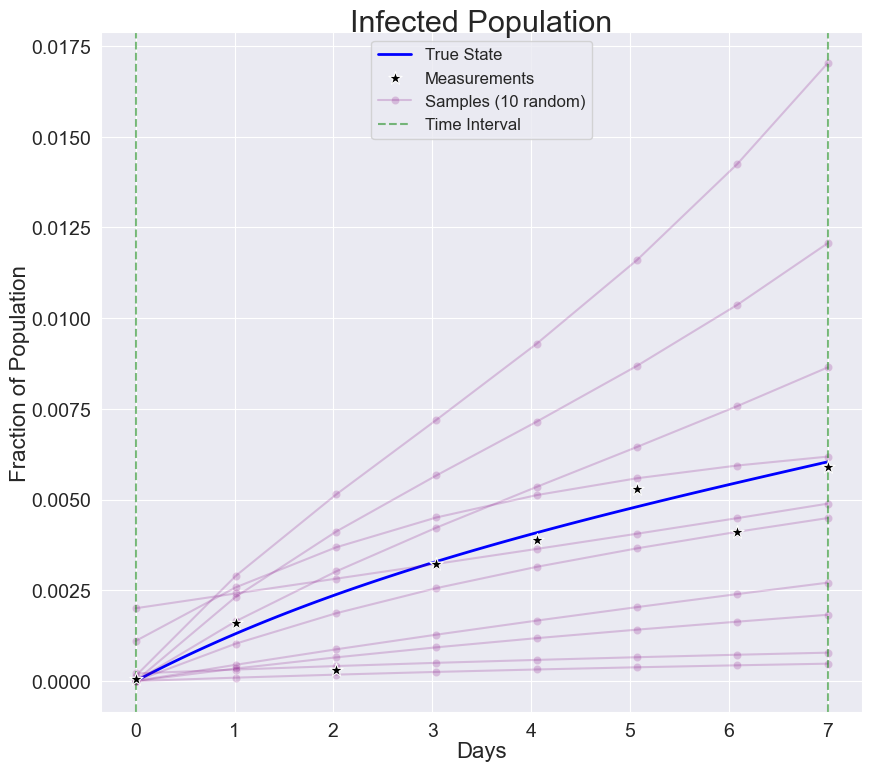

In [4]:
# enable_log(level='DEBUG')
disable_log()

pi_in, samples = sr.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
sr.get_data(7)
sr.forward_solve(samples)
sr.plot_infected()

In [133]:
import pandas as pd
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=3)
pd.DataFrame(search_combs)

search_combs = [{
   'exp_thresh': 0.2,
   'pca_components': [[0]],
   'pca_splits': 2
}]

In [6]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=3, all_data=True)
search_combs

[{'exp_thresh': 10000000000.0,
  'pca_components': [[0]],
  'pca_mask': range(0, 8),
  'pca_splits': 1},
 {'exp_thresh': 10000000000.0,
  'pca_components': [[0]],
  'pca_mask': range(0, 8),
  'pca_splits': 2}]

In [134]:
disable_log()
res_1 = sr.solve_search(
    search_combs,
    exp_thresh=0.2,
    best_method="max_kl",
    pi_in=pi_in)
search_res_1 = get_l2_errs(res_1['search_results'], SEIRS_P1)
best.append(res_1['best'])

Solving for different combinations |████████████████████████████████████████| 1/


e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  0.980294  1.036283   0.165348   0.114875   0.083488   0.001168      523   

  pca_components     pca_mask  i  index  predict_delta  within_thresh  \
0            [0]  range(4, 8)  1      0       0.019706           True   

   closest  max_kl  min_kl   l2_err   rel_err  
0     True    True    True  0.05767  0.215771

In [121]:
best[0].it_results

e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  1.062468  1.294052   0.099890   0.193539   0.117335   0.001367      380   
0  0.947284  3.347988   0.354853   0.085463   0.068537   0.003161      584   

  pca_components       pca_mask  i  
0            [0]   range(0, 11)  0  
0            [0]  range(11, 21)  1

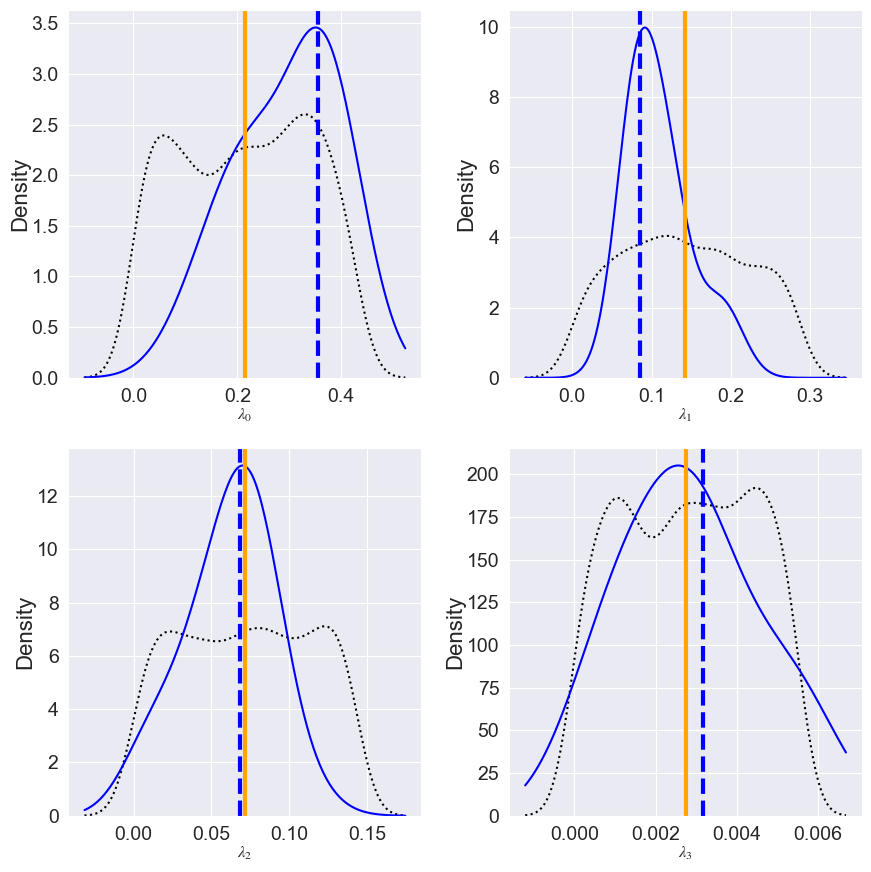

In [122]:
plot_iterations(best, lam_true=[SEIRS_P1])

### Second Iteration

In [55]:
samples = best[0].sample_dist(num_samples=n_samples)

Solving model sample set: |                    | ▁▃▅ 1/1000 [0%] in 0s (~0s, 208

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (4617.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

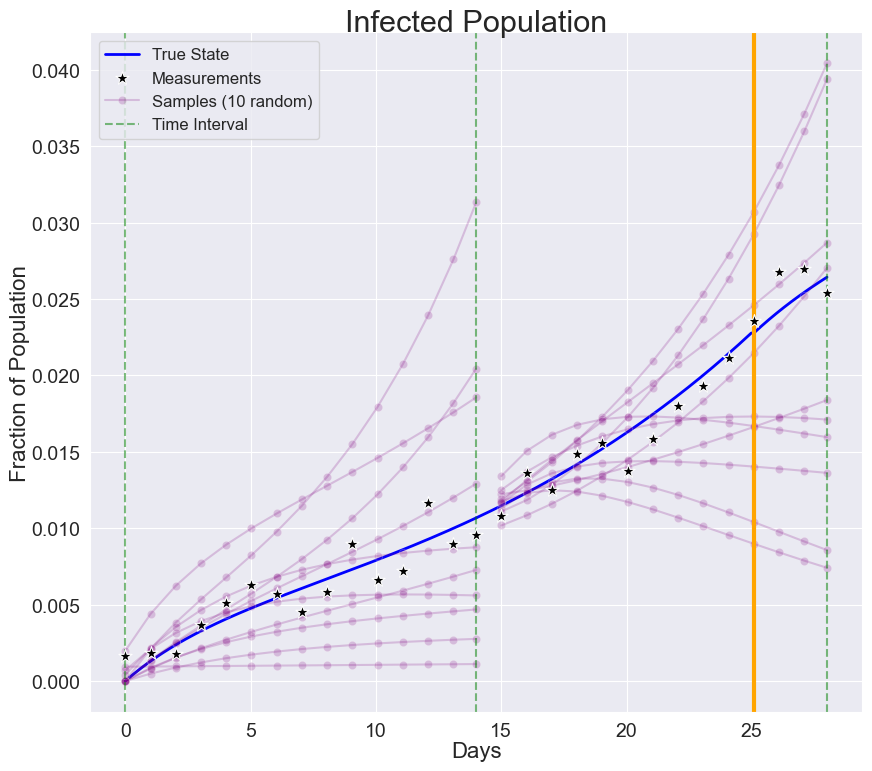

In [56]:
disable_log()

sr.get_data(data_chunk_size)
sr.forward_solve(samples)
sr.plot_infected()

In [58]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=7)
pd.DataFrame(search_combs)

exp_thresh pca_components  \
0  1.000000e+10          [[0]]   
1  1.000000e+10          [[0]]   
2  1.000000e+10          [[0]]   

                                         pca_mask  pca_splits  
0                           (0, 1, 2, 3, 4, 5, 6)           1  
1  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)           1  
2  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)           2

In [ ]:
disable_log()
res_2 = sr.solve_search(search_combs,
                      exp_thresh=0.5,
                      best_method="max_kl",
                      pi_in=pi_in)
search_res_2 = get_l2_errs(res_2['search_results'], SEIRS_P1)
best.append(res_2['best'])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_2

e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  1.058830  2.283828   0.229384   0.127783   0.064973   0.002731      648   
0  0.964375  3.218909   0.134777   0.116725   0.029469   0.002514      138   
0  0.082564  3.013896   0.327144   0.165581   0.131574   0.001948      272   

  pca_components     pca_mask  i  index  predict_delta  within_thresh  \
0            [0]  range(0, 7)  0      0       0.058830           True   
0         [0, 1]  range(0, 7)  0      1       0.035625           True   
0      [0, 1, 2]  range(0, 7)  0      2       0.917436          False   

   closest  max_kl  min_kl    l2_err   rel_err  
0    False   False    True  0.022290  0.083398  
0     True    True   False  0.093622  0.350283  
0    False   False   False  0.129891  0.485980

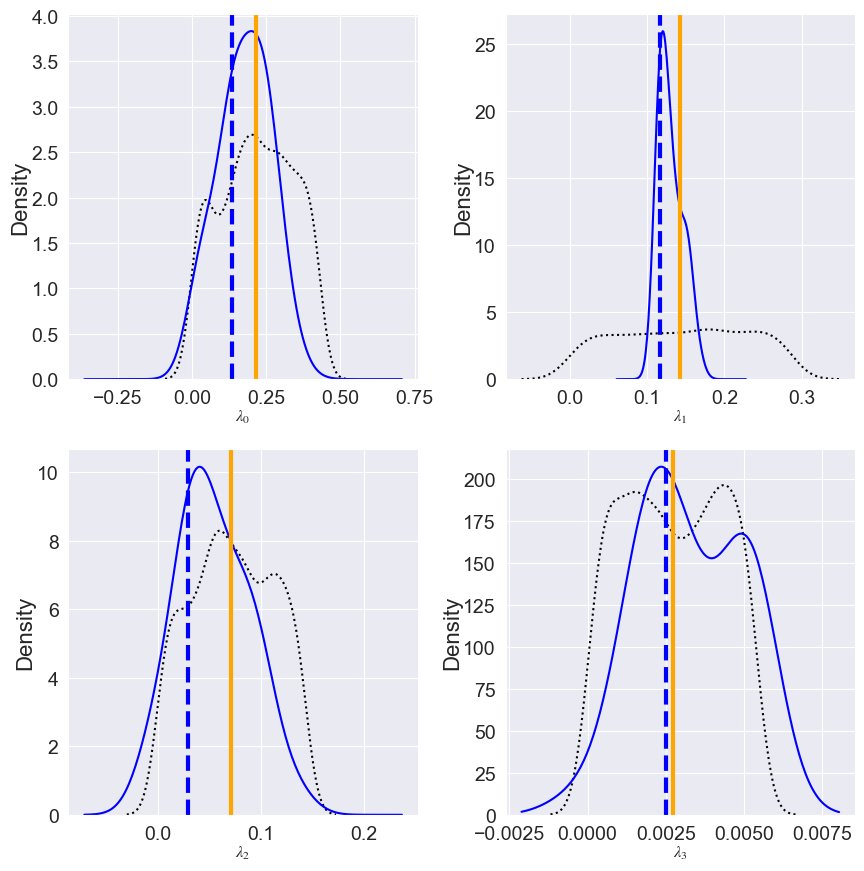

In [ ]:
plot_iterations(best, lam_true=[SEIRS_P1])

### Third Iteration

In [ ]:
samples = best[1].sample_dist(num_samples=n_samples)

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (6131.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

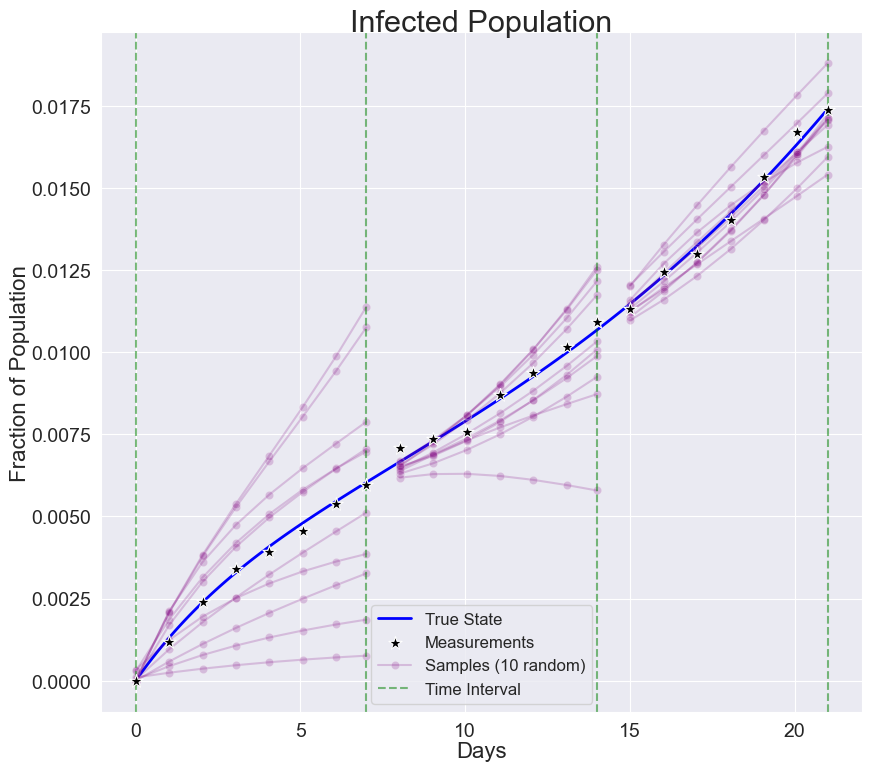

In [ ]:
sr.get_data(3*n_weeks*7)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=data_chunk_size)
pd.DataFrame(search_combs)

exp_thresh pca_components               pca_mask  pca_splits
0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6)           1
1  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6)           1
2  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6)           1

In [ ]:
disable_log()
res_3 = sr.solve_search(search_combs,
                      exp_thresh=0.5,
                      best_method="max_kl",
                      pi_in=pi_in)
search_res_3 = get_l2_errs(res_3['search_results'], SEIRS_P1)
best.append(res_3['best'])
search_res_3

Solving for different combinations |████████████████████████████████████████| 3/


e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  1.056461  1.048761   0.205307   0.136466   0.065253   0.006360       19   
0  1.130793  1.682465   0.222689   0.125593   0.059344   0.002354      727   
0  0.973798  1.747766   0.133617   0.117060   0.025240   0.002020      752   

  pca_components     pca_mask  i  index  predict_delta  within_thresh  \
0            [0]  range(0, 7)  0      0       0.056461           True   
0         [0, 1]  range(0, 7)  0      1       0.130793           True   
0      [0, 1, 2]  range(0, 7)  0      2       0.026202           True   

   closest  max_kl  min_kl    l2_err   rel_err  
0    False   False    True  0.013142  0.049169  
0    False   False   False  0.022690  0.084895  
0     True    True   False  0.096472  0.360946

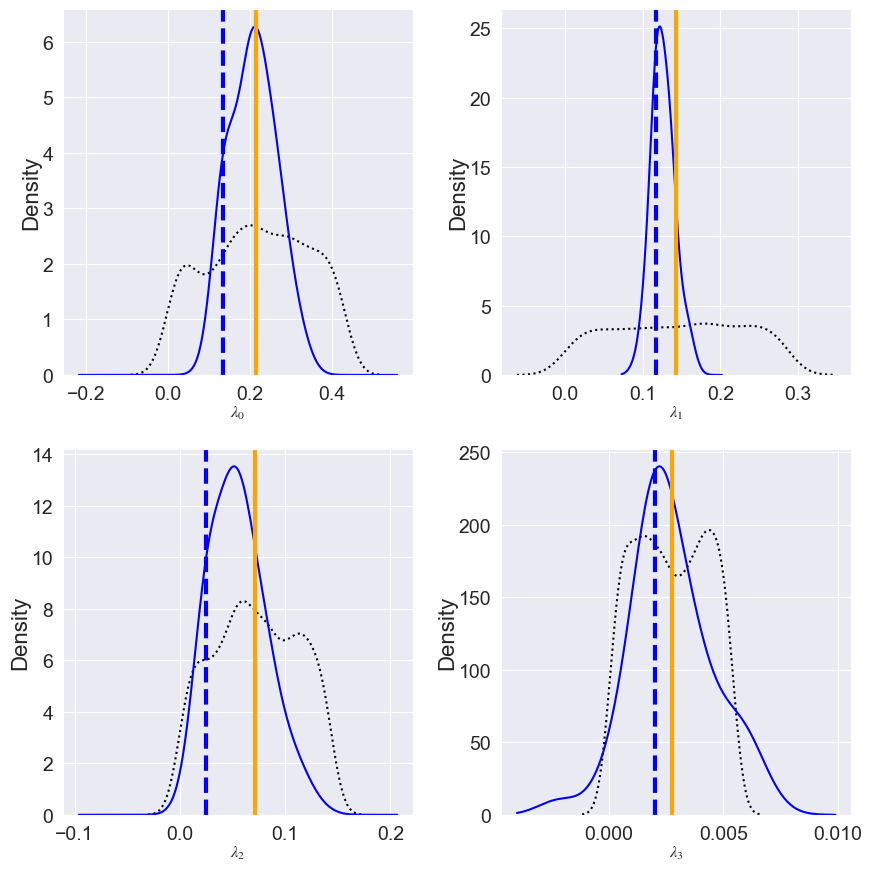

In [ ]:
plot_iterations(best, lam_true=[SEIRS_P1])

### Fourth Iteration -> Shift

In [ ]:
samples = best[2].sample_dist(num_samples=n_samples)

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (5899.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

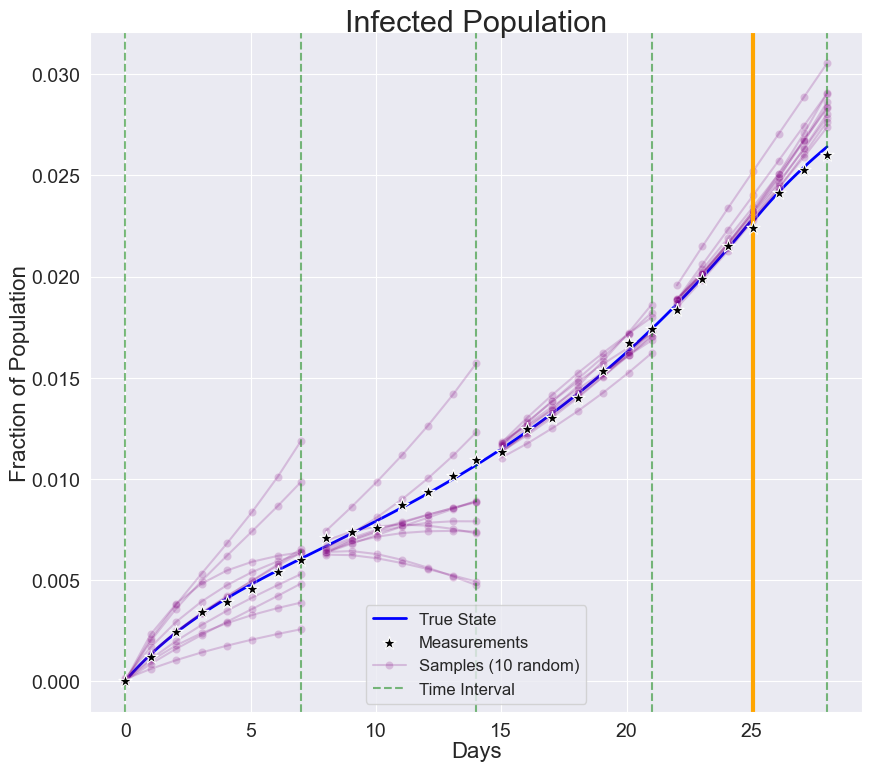

In [ ]:
sr.get_data(4*n_weeks*7)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=data_chunk_size)
pd.DataFrame(search_combs)

exp_thresh pca_components               pca_mask  pca_splits
0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6)           1
1  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6)           1
2  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6)           1

In [ ]:
disable_log()
res_4 = sr.solve_search(search_combs,
                      exp_thresh=0.5,
                      best_method="max_kl",
                      pi_in=pi_in)
search_res_4 = get_l2_errs(res_4['search_results'], SEIRS_P1)
best.append(res_4['best'])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_4

e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  0.944136  3.011576   0.191607   0.110373   0.045725   0.006332      486   
0  0.022512  8.512823   0.256762   0.164529   0.111781   0.004121      369   
0  0.000004  7.216180   0.235575   0.157362   0.094580   0.007446      787   

  pca_components     pca_mask  i  index  predict_delta  within_thresh  \
0            [0]  range(0, 7)  0      0       0.055864           True   
0         [0, 1]  range(0, 7)  0      1       0.977488          False   
0      [0, 1, 2]  range(0, 7)  0      2       0.999996          False   

   closest  max_kl  min_kl    l2_err   rel_err  
0     True    True    True  0.047362  0.177202  
0    False   False   False  0.062483  0.233779  
0    False   False   False  0.034954  0.130777

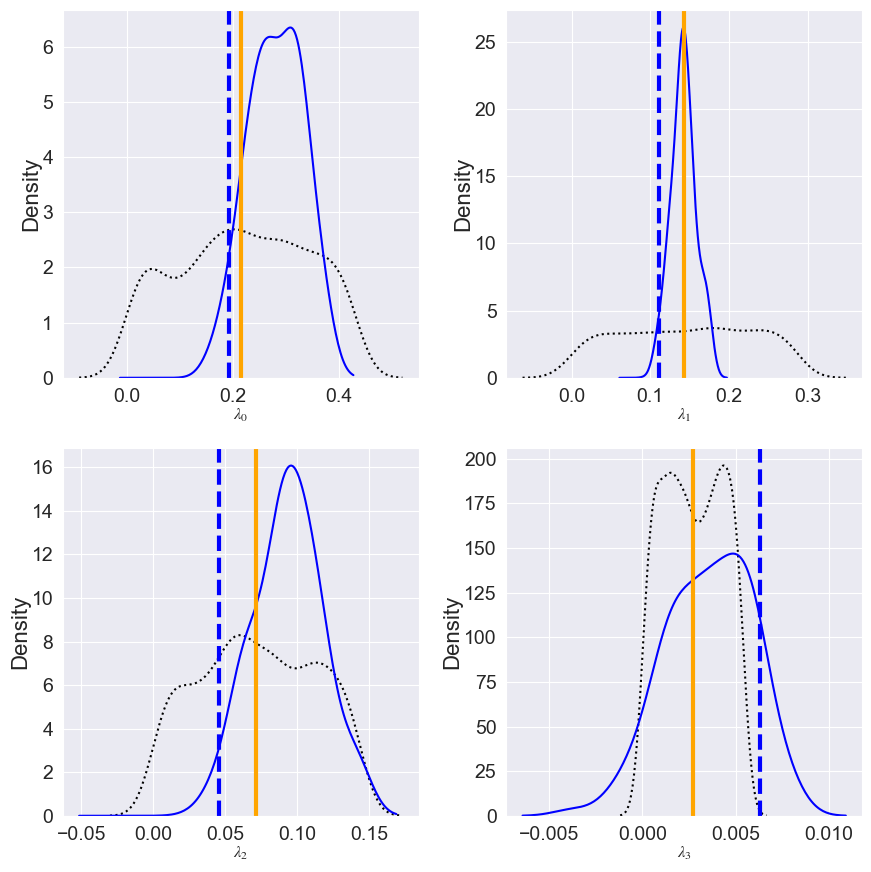

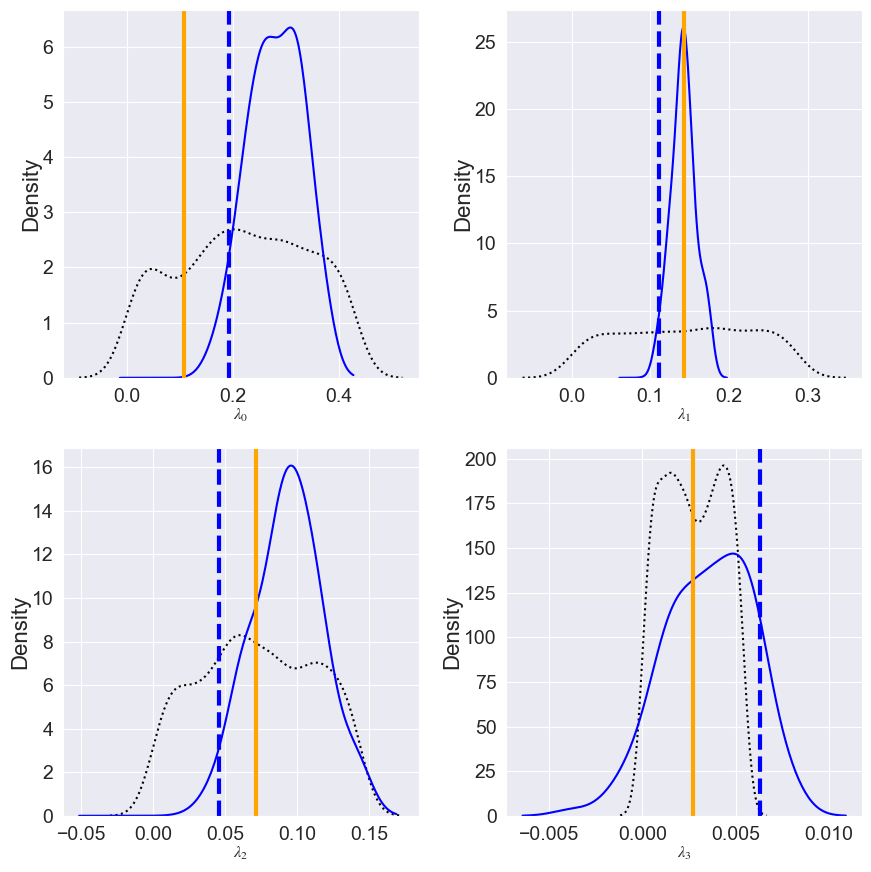

In [ ]:
# TODO: Improve thie plot to show both shifts on same param plots
plot_iterations(best, lam_true=[SEIRS_P1])
plot_iterations(best, lam_true=[SEIRS_P2])

### Fifth Iteration

In [ ]:
samples = best[3].sample_dist(num_samples=n_samples)

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (4271.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

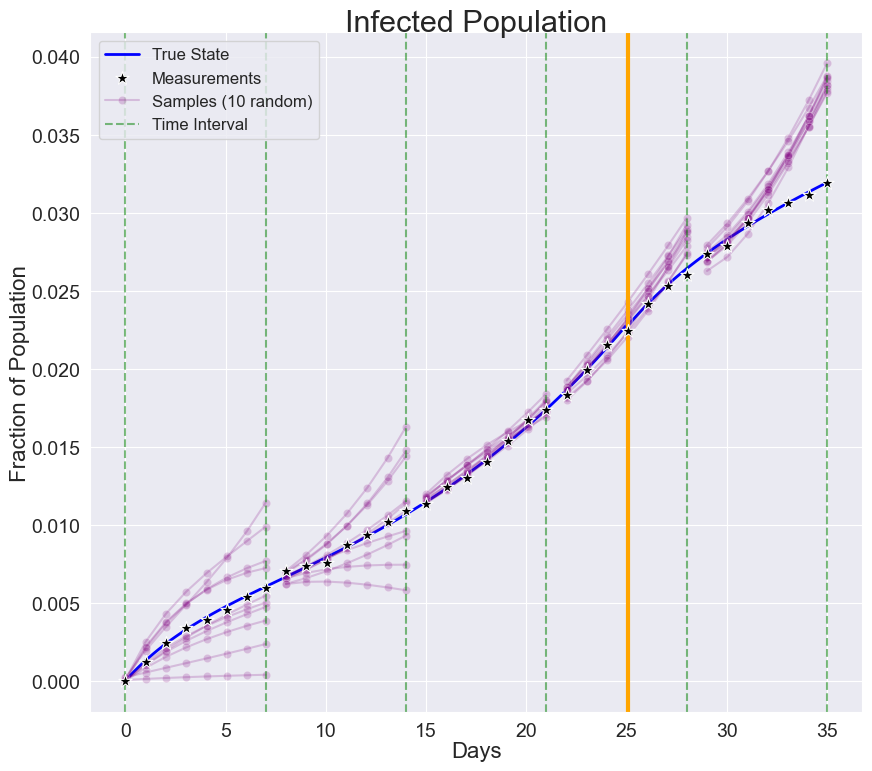

In [ ]:
sr.get_data(5*n_weeks*7)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=data_chunk_size)
pd.DataFrame(search_combs)

exp_thresh pca_components               pca_mask  pca_splits
0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6)           1
1  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6)           1
2  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6)           1

In [ ]:
disable_log()
res_5 = sr.solve_search(search_combs,
                      exp_thresh=0.5,
                      best_method="max_kl",
                      pi_in=pi_in)
search_res_5 = get_l2_errs(res_5['search_results'], SEIRS_P1)
best.append(res_5['best'])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_5

e_r         kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  \
0   5.847788e-16  11.215081   0.278968   0.168295   0.121212   0.004128   
0  1.644582e-124   9.866095   0.269825   0.161706   0.114015   0.002475   
0  2.732573e-126   9.201269   0.269825   0.161706   0.114015   0.002475   

   MUD_idx pca_components     pca_mask  i  index  predict_delta  \
0      454            [0]  range(0, 7)  0      0            1.0   
0      203         [0, 1]  range(0, 7)  0      1            1.0   
0      203      [0, 1, 2]  range(0, 7)  0      2            1.0   

   within_thresh  closest  max_kl  min_kl    l2_err   rel_err  
0          False    False   False   False  0.085506  0.319916  
0          False    False   False   False  0.072481  0.271186  
0          False    False   False   False  0.072481  0.271186

### Fifth Iteation - Retrying

Retry chunk, but reset to initial distribution.


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.1s (6647.


<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

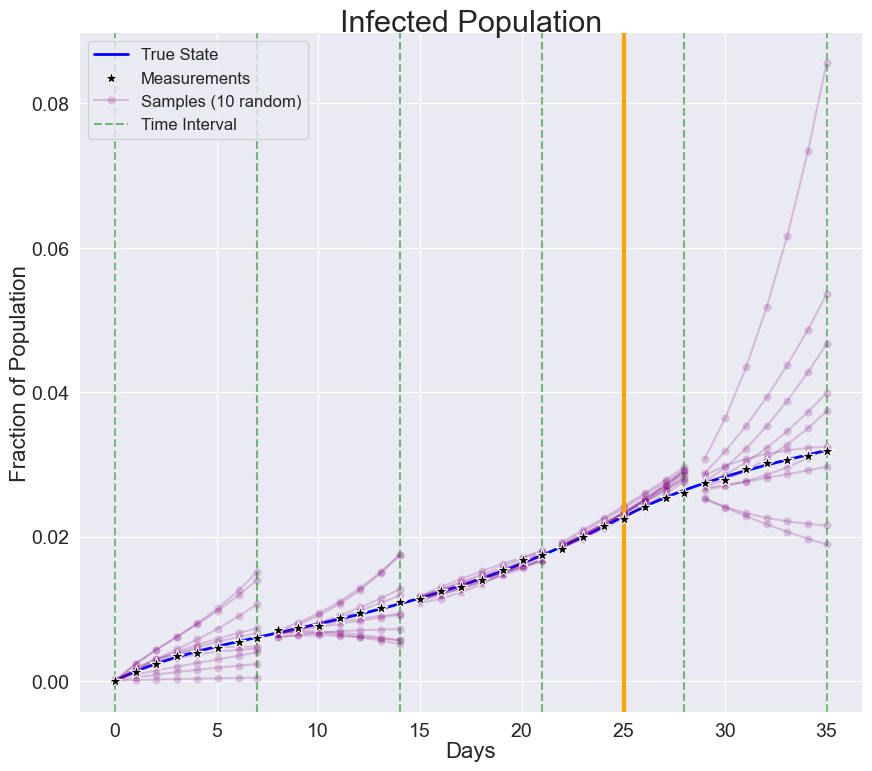

In [ ]:
pi_in, samples = sr.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
sr.forward_solve(samples)
sr.plot_infected()

In [ ]:
search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=data_chunk_size)
pd.DataFrame(search_combs)

exp_thresh pca_components               pca_mask  pca_splits
0  1.000000e+10          [[0]]  (0, 1, 2, 3, 4, 5, 6)           1
1  1.000000e+10       [[0, 1]]  (0, 1, 2, 3, 4, 5, 6)           1
2  1.000000e+10    [[0, 1, 2]]  (0, 1, 2, 3, 4, 5, 6)           1

In [ ]:
disable_log()
res_5 = sr.solve_search(search_combs,
                      exp_thresh=0.5,
                      best_method="max_kl",
                      pi_in=pi_in)
search_res_5 = get_l2_errs(res_5['search_results'], SEIRS_P1)
best.append(res_5['best'])

Solving for different combinations |████████████████████████████████████████| 3/


In [ ]:
search_res_5

e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  1.201652  3.707657   0.070814   0.099673   0.041858   0.001024      602   
0  1.675196  6.133261   0.070814   0.099673   0.041858   0.001024      602   
0  1.281728  5.935910   0.070814   0.099673   0.041858   0.001024      602   

  pca_components     pca_mask  i  index  predict_delta  within_thresh  \
0            [0]  range(0, 7)  0      0       0.201652           True   
0         [0, 1]  range(0, 7)  0      1       0.675196          False   
0      [0, 1, 2]  range(0, 7)  0      2       0.281728           True   

   closest  max_kl  min_kl   l2_err   rel_err  
0     True   False    True  0.15273  0.571433  
0    False   False   False  0.15273  0.571433  
0    False    True   False  0.15273  0.571433

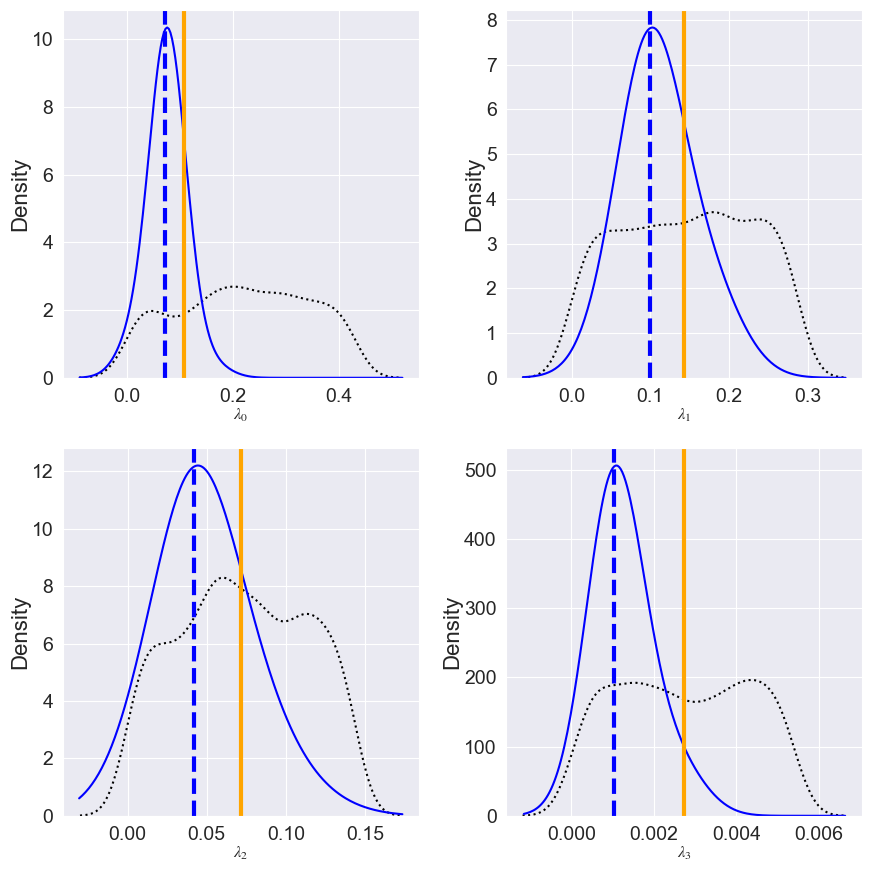

In [ ]:
plot_iterations(best, lam_true=[SEIRS_P2])

## Full Algorithm - Drafts

In [ ]:
def online_solve(self,
                 num_its=1,
                 max_nc=3,
                 data_chunk_size=7,
                 num_samples=100):
    """
    Online Solve
    """
    search_res = []
    bad_res = []
    scale = 1.0

    if len(self.probs) == 0:
        pi_in, samples = self.get_uniform_initial_samples(
            num_samples=num_samples,
            scale=1.0)
        it = 1
    else:
        pi_in = self.probs[-1].dists['pi_up']
        it = len(self.probs)

    max_its = it + num_its
    best_flag = np.empty((num_samples, 1), dtype=bool)
    while it < max_its:
        if it > len(self.data):
            # logger.info(f"Getting data for iteration {it}")
            self.get_data(it*data_chunk_size)

        self.forward_solve(samples)
        search_combs = self.get_search_combinations(
            max_nc=max_nc,
            data_chunk_size=data_chunk_size
        )
        disable_log()
        res = self.solve_search(
            search_combs,
            exp_thresh=0.1,
            best_method="max_kl",
            pi_in=pi_in
        )
        if res['best'] is None:
            avg_kl = np.mean(res['search_results']['kl'])
            logger.info(f'Suspected shift in params at {it}: KL Divergence: {avg_kl}')
            pi_in, samples = self.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
            bad_res.append((it, res))
        else:
            # logger.info(f"Best solution found:{res['best'].result}")
            self.probs.append(res['best'])
            best_flag[:] = False
            best_flag[res['best'].mud_arg] = True
            self.samples[-1]["best_flag"] = best_flag
            samples= self.probs[-1].sample_dist(num_samples=num_samples)
            pi_in = self.probs[-1].dists['pi_up']
            it += 1


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from pydci.examples import seirs
import importlib
from pydci.log import enable_log, disable_log, logger
from pydci.utils import get_l2_errs

importlib.reload(seirs)

n_weeks = 1
max_nc = 3
max_weeks = 2 # 1 year simulation
data_chunk_size = n_weeks*7
n_samples = 1000

best = []
sr = seirs.SEIRSModel(lam_true=SEIRS_P1,
                      param_shifts=param_shifts,
                      measurement_noise=5*SEIRS_NOISE,
                      sample_ts=SEIRS_SAMPLE_TS,
                      state_mins=SEIRS_STATE_MINS,
                      state_maxs=SEIRS_STATE_MAXS)

it = 1
search_res = []
bad_res = []
scale = 1.0
pi_in, samples = sr.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
best_flag = np.empty((n_samples, 1), dtype=bool)
while it < max_weeks:
    if it > len(sr.data):
        # logger.info(f"Getting data for iteration {it}")
        sr.get_data(data_chunk_size)

    sr.forward_solve(samples)
    search_combs = sr.get_search_combinations(max_nc=max_nc, data_chunk_size=data_chunk_size)
    disable_log()
    res = sr.solve_search(
        search_combs,
        exp_thresh=0.1,
        best_method="max_kl",
        pi_in=pi_in
    )
    if res['best'] is None:
        avg_kl = np.mean(res['search_results']['kl'])
        logger.info(f'Suspected shift in params at {it}: KL Divergence: {avg_kl}')
        pi_in, samples = sr.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
        bad_res.append((it, res))
    else:
        # logger.info(f"Best solution found:{res['best'].result}")
        best.append(res['best'])
        best_flag[:] = False
        best_flag[res['best'].mud_arg] = True
        sr.samples[-1]["best_flag"] = best_flag
        samples= best[-1].sample_dist(num_samples=n_samples)
        pi_in = best[-1].dists['pi_up']
        it += 1
        search_res.append(get_l2_errs(res['search_results'], SEIRS_P1))


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.2s (6456.
Solving for different combinations |████████████████████████████████████████| 3/


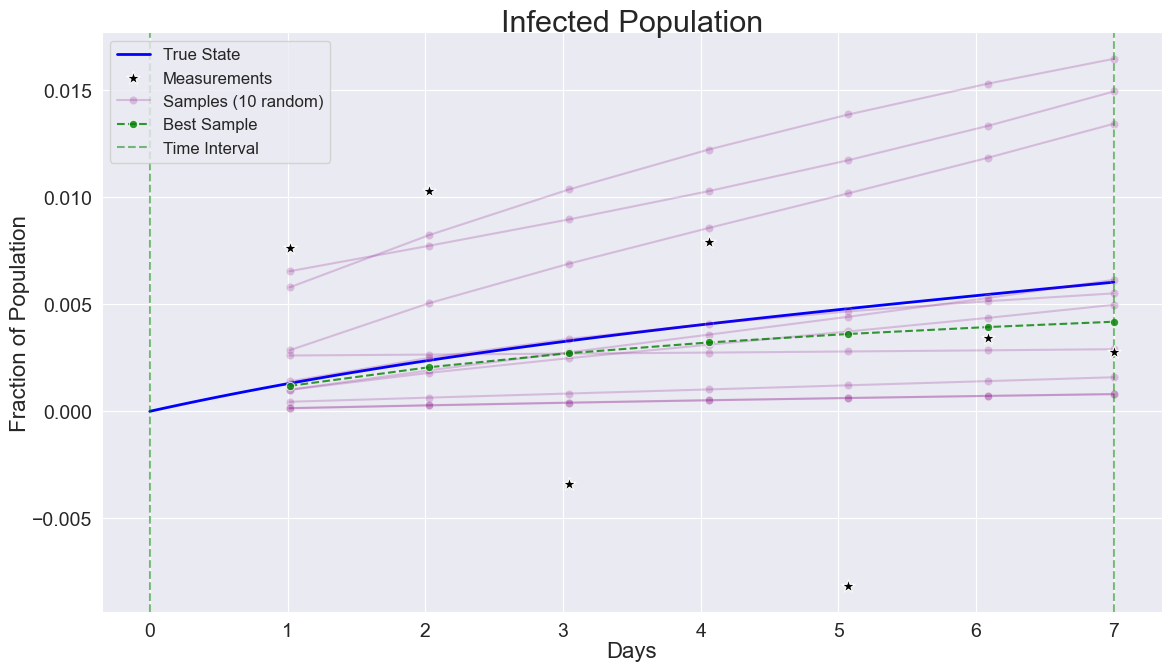

In [ ]:
ax = sr.plot_infected(figsize=(12,7), plot_samples=True, n_samples=10)

(<AxesSubplot: xlabel='$\\lambda_0$', ylabel='Density'>,
 ['$\\pi^{in}_{\\lambda_0}$',
  '$\\pi^{up}_{\\lambda_0}$',
  '$\\lambda^{MUD}_0 = 0.2133$'])

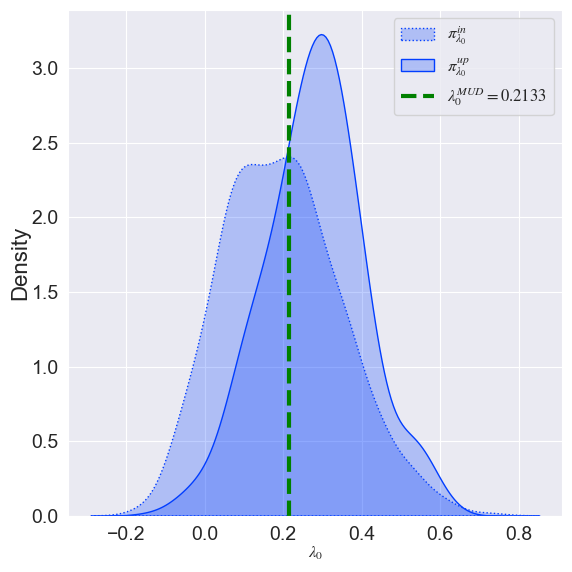

In [ ]:
best[3].plot_L(param_idx=0)

## First Shift - "Flattening the Curve"

Can we pick up shift in actual transmission rate as a result of a lockdown or other type of policy to reduce transmission rate?
This is the "flattening the curve" idea, where we want to reduce peak of the infected individuals during an outbreak.

IndexError: list index out of range

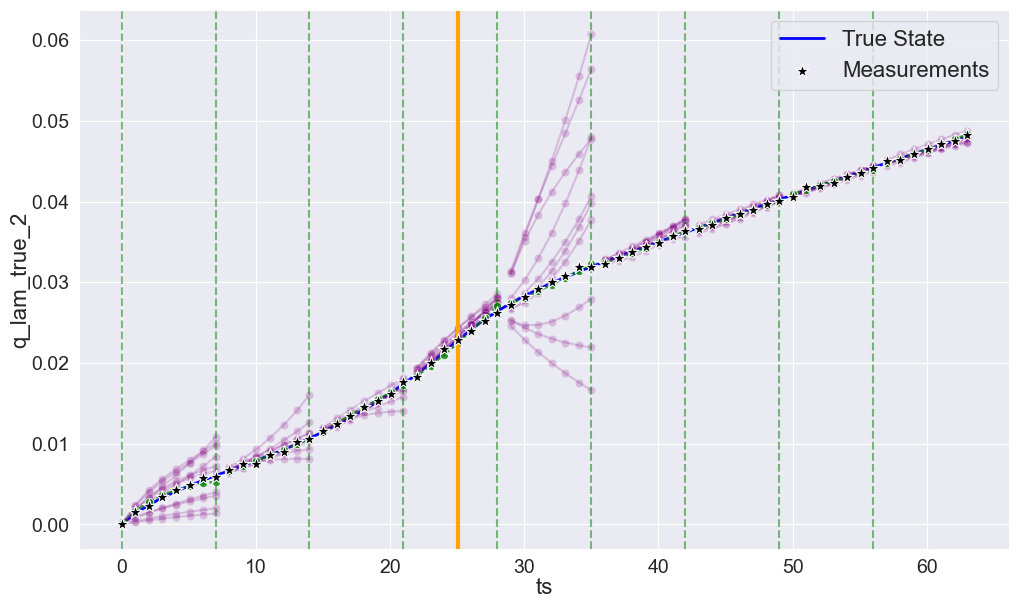

In [ ]:
ax = sr.plot_infected(figsize=(12,7), plot_samples=True, n_samples=10, iterations=list(range(10))) 
ax.set_ylim(ax.get_ylim()[0], 0.1)

### Transmission Rate Shift

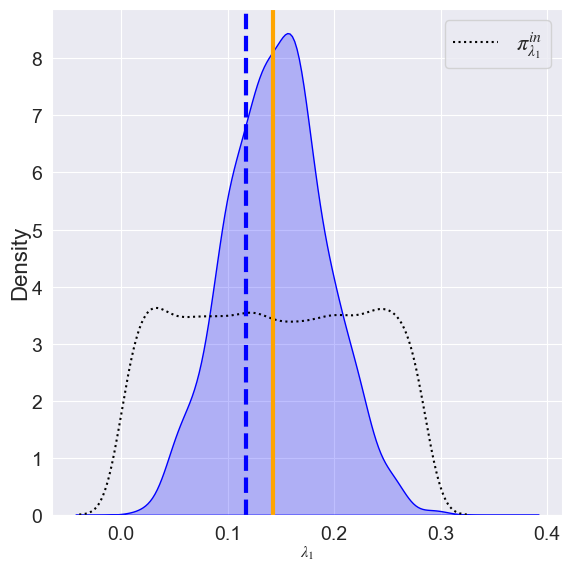

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

param_idx = 1
iterations = range(5)

# Plot Initial at start of iterations
_, labels = best[iterations[0]].plot_L(ax=ax,
                param_idx=param_idx,
                initial_kwargs={"color": "black", "linestyle": ":", "fill": False},
                update_kwargs=None,
                plot_legend=False,
                mud_kwargs=None,
                lam_true=None
)
ax.legend(labels)

# Plot updates in between

_, labels = best[iterations[-1]].plot_L(ax=ax,
                param_idx=param_idx,
                initial_kwargs=None,
                update_kwargs={"color": "blue", "linestyle": "-", "fill": True},
                plot_legend=False,
                mud_kwargs={'color': 'blue'},
                lam_true=[SEIRS_P1],
)

IndexError: list index out of range

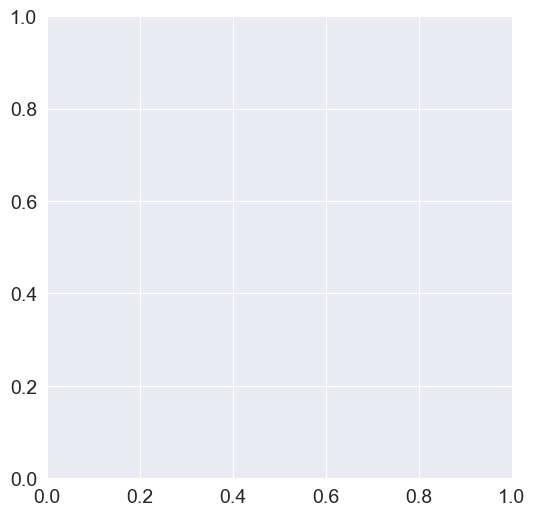

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

true_vals = np.array([SEIRS_P1, SEIRS_P2, SEIRS_P3])
iterations = range(0, 10)
param_idx = 0

# Plot initial at first iteration
best[iterations[0]].plot_L(ax=ax,
                param_idx=i,
                initial_kwargs={"color": "black", "linestyle": ":", "fill": False},
                update_kwargs=None,
                plot_legend=False,
                mud_kwargs=None,
                lam_true=None
)

for i  in iterations[1:-1]:
    best[i].plot_L(ax=ax,
                    param_idx=param_idx,
                    initial_kwargs=None,
                    update_kwargs={"color": "blue", "linestyle": "-", "fill": False},
                    plot_legend=False,
                    mud_kwargs=None,
                    lam_true=None
    )

# Plot update at final iteration
best[-1].plot_L(ax=ax,
                param_idx=i,
                initial_kwargs=None,
                update_kwargs={"color": "blue", "linestyle": "-", "fill": False},
                plot_legend=False,
                mud_kwargs={'color': 'blue'},
                lam_true=None,
)

## Second Shift - Virus Mutation

Virus mutation, leading to a straing that spreads and infects quicker.
Thus the rate of infection and rate of transmission go up. 
Difference in these two rates can be due to the fact that the virus for example

1. Can survive longer outside of a host, or can transmit through new means, hence increasing the transmission rate.
2. Infects a host faster once a host has been exposed to it. 

This leads to what is known as a "second wave" in the outbreak, as we saw with the COVID-19 mutations suchas omicron and delta.

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

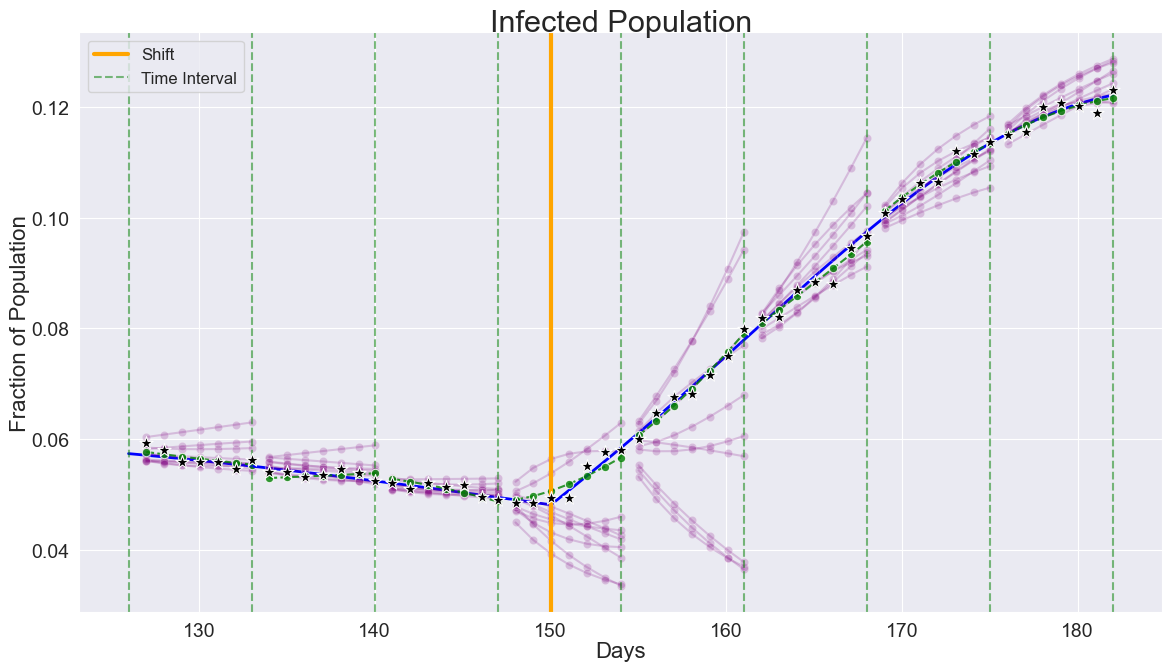

In [ ]:
sr.plot_infected(figsize=(12,7), plot_samples=True, n_samples=10, iterations=list(range(18,26))) 

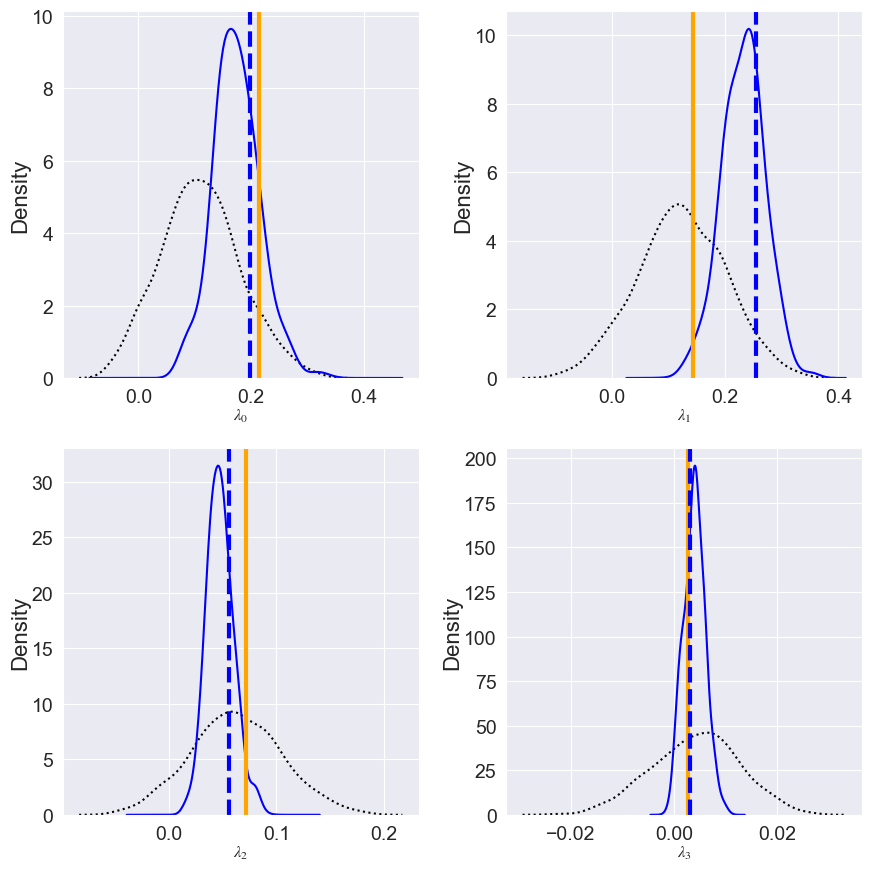

In [ ]:
plot_iterations(best[18:25], lam_true=[SEIRS_P1])

## Metrics over iterations - $\mathbb{E}(r)$ and $\mathrm{KL(\pi^\mathrm{up}_{i}|\pi^\mathrm{init})}$



In [ ]:
kl_vals = [x.result['kl'].values[0] for x in best]
e_r = [x.expected_ratio() for x in best]

In [ ]:
bad_kl = np.array([[7*x[0], x[1]['search_results']['kl'].mean()] for x in bad_res])
bad_e_r = np.array([[7*x[0], x[1]['search_results']['e_r'].mean()] for x in bad_res])

In [ ]:
bad_e_r

array([[3.50000000e+01, 3.62664017e-64]])

<AxesSubplot: >

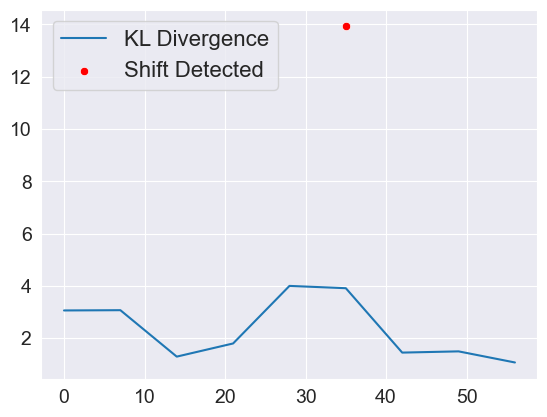

In [ ]:
import seaborn as sns
sns.lineplot(x=7*np.arange(len(kl_vals)), y=kl_vals, label='KL Divergence')
sns.scatterplot(x=bad_kl[:,0], y=bad_kl[:,1], label='Shift Detected', color='red')

<AxesSubplot: >

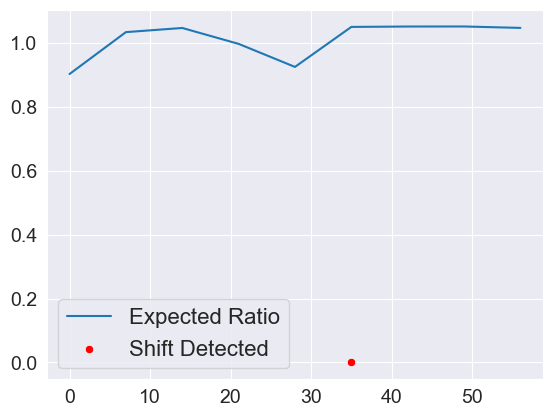

In [ ]:
import seaborn as sns
sns.lineplot(x=7*np.arange(len(e_r)), y=e_r, label='Expected Ratio')
sns.scatterplot(x=bad_e_r[:,0], y=bad_e_r[:,1], label='Shift Detected', color='red')

In [ ]:
from pydci.utils import get_df, put_df
import pandas as pd


for j in range(len(sr.data)):
    mud_est = get_df(sr.samples[j][sr.samples[j]['best_flag']], 'lam', size=sr.n_params)
    for i in range(sr.n_params):
        sr.data[j][f'lam_MUD_{i}'] = np.ones((len(sr.data[j]), 1)) * mud_est[0][i]
        sr.data[j][f'lam_{i}_l2'] = np.linalg.norm(sr.data[j][f'lam_true_{i}'] - sr.data[j][f'lam_MUD_{i}'])
        sr.data[j][f'lam_{i}_l2_rel'] = sr.data[j][f'lam_{i}_l2'] / np.linalg.norm(sr.data[j][f'lam_true_{i}'])

# Calculate relative l2 error between lam_true_{i} columns and lam_MUD_{i} columns
# for i in range(sr.n_params):
#     all_data[f'lam_{i}_l2'] = np.linalg.norm(all_data[f'lam_true_{i}'] - all_data[f'lam_MUD_{i}'])
#     all_data[f'lam_{i}_l2_rel'] = all_data[f'lam_{i}_l2'] / np.linalg.norm(all_data[f'lam_true_{i}'])
# 
# all_data
all_data = pd.concat(sr.data)


<AxesSubplot: xlabel='ts', ylabel='lam_3_l2_rel'>

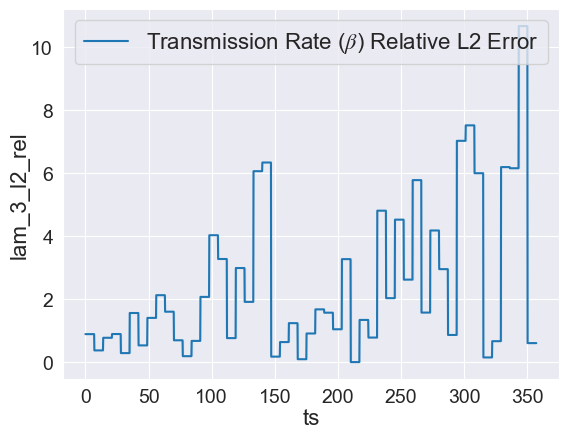

In [ ]:
import seaborn as sns
sns.lineplot(x='ts', y='lam_3_l2_rel', data=all_data, label='Transmission Rate ($\\beta$) Relative L2 Error')   

In [ ]:
# Nomr between to pandas collumns
sr.data[0]

ts  shift_idx  sample_flag  lam_true_0  q_lam_true_0  q_lam_true_1  \
0   0.000000          0         True    0.214286      0.990000      0.010000   
1   0.101449          0        False    0.214286      0.989998      0.009858   
2   0.202899          0        False    0.214286      0.989994      0.009720   
3   0.304348          0        False    0.214286      0.989986      0.009588   
4   0.405797          0        False    0.214286      0.989976      0.009461   
..       ...        ...          ...         ...           ...           ...   
65  6.594203          0        False    0.214286      0.985397      0.007271   
66  6.695652          0        False    0.214286      0.985273      0.007290   
67  6.797101          0        False    0.214286      0.985148      0.007310   
68  6.898551          0        False    0.214286      0.985021      0.007331   
69  7.000000          0         True    0.214286      0.984893      0.007354   

    q_lam_true_2  q_lam_true_3  q_lam_obs_0  lam_MUD_0  lam_MUD_1  lam_MUD_2  \
0       0.000000  0.000000e+00    -0.000659   0.131979   0.136436   0.084464   
1       0.000143  5.202547e-07          NaN   0.131979   0.136436   0.084464   
2       0.000284  2.067981e-06          NaN   0.131979   0.136436   0.084464   
3       0.000421  4.622827e-06          NaN   0.131979   0.136436   0.084464   
4       0.000556  8.163621e-06          NaN   0.131979   0.136436   0.084464   
..           ...           ...          ...        ...        ...        ...   
65      0.005785  1.546703e-03          NaN   0.131979   0.136436   0.084464   
66      0.005848  1.588417e-03          NaN   0.131979   0.136436   0.084464   
67      0.005912  1.630578e-03          NaN   0.131979   0.136436   0.084464   
68      0.005975  1.673185e-03          NaN   0.131979   0.136436   0.084464   
69      0.006037  1.716235e-03     0.004718   0.131979   0.136436   0.084464   

    lam_MUD_3  
0    0.002733  
1    0.002733  
2    0.002733  
3    0.002733  
4    0.002733  
..        ...  
65   0.002733  
66   0.002733  
67   0.002733  
68   0.002733  
69   0.002733  

[70 rows x 13 columns]

In [ ]:
## Per Parameter, l2 error over each iteration

def process_iterations(iterations=None):
    """
    """
    iterations = iterations if iterations is not None else range(len(self.data))

    for it in iterations:
        data = self.data[]


# Using All States



In [ ]:
import numpy as np
from pydci.examples import seirs
import importlib

importlib.reload(seirs)

sr = seirs.SEIRSModel()

Solving model sample set: |⚠︎                   | (!) 0/2 [0%] in 0.1s (0.00/s)  


TypeError: 'rv_continuous_frozen' object is not iterable

In [ ]:
import pandas as pd
from numpy.linalg import LinAlgError
import seaborn as sns
from pydci.log import enable_log, disable_log
import math 
from alive_progress import alive_bar
from pydci import PCAMUDProblem
from pydci.log import logger
import numpy as np
import pandas as pd

def solve_search(
    self,
    prob_args, 
    search_list,
    def_args = None,
    exp_thresh: float = 0.5,
    best_method: str = "closest",
):
    """
    Search through different iterations of solvign the PCA problem

    Thea idea of this method is, given a chunk of data, and a list of
    different iterative solve arguments, solve them and determine
    the "best" solution

    # TODO: Move this inside of Model class: self -> self

    Parameters
    ----------
    """

    am = ["closest", "min_kl", "max_kl"]
    if best_method not in am:
        msg = f"Unrecognized best method {best_method}. Allowed: {am}"
        raise ValueError(msg)
    if exp_thresh <= 0:
        msg = f"Expected ratio thresh must be a float > 0: {exp_thresh}"
        raise ValueError(msg)

    all_search_results = []
    all_results = []
    with alive_bar(
        len(search_list),
        title="Solving for different combinations",
        force_tty=True,
        receipt=True,
        length=40,
    ) as bar:
        for idx, args in enumerate(search_list):
            args.update(def_args if def_args is not None else {})

            # Solve -> Saves states in state dictionary
            prob = PCAMUDProblem(prob_args['samples'],
                                 prob_args['data'],
                                 self.measurement_noise,
                                 pi_in=prob_args['pi_in'])
                                 
            try:
                prob.solve_it(**args, state_extra={"search_index": idx})
            except ZeroDivisionError or KDEError as e:
                logger.error(f"Failed: Ill-posed problem: {e}")
                continue 
            except RuntimeError as r:
                if "No solution found within exp_thresh" in str(r):
                    logger.error(f"Failed: No solution in exp_thresh: {r}")
                    continue
                else:
                    raise r
            except LinAlgError as e:
                logger.exception(str(e))
                return prob
            else:
                # ! What state do we need to whipe here to ensure back to original conditions of search on next iteration?
                # Store results per each iteration and final result
                # This will be erased the next iteration if we don't store it
                all_search_results.append(prob.it_results.copy())
                all_search_results[-1]["index"] = idx
                all_results.append(prob.result.copy())
                all_results[-1]["index"] = idx

            bar()

    # Parse DataFrame with results of mud estimations for each ts choice
    res_df = pd.concat(all_results)
    res_df["predict_delta"] = np.abs(res_df["e_r"] - 1.0)
    res_df["within_thresh"] = res_df["predict_delta"] <= exp_thresh
    res_df["closest"] = np.logical_and(
        res_df["predict_delta"]
        <= res_df[res_df["within_thresh"]]["predict_delta"].min(),
        res_df["within_thresh"],
    )
    res_df["max_kl"] = np.logical_and(
        res_df["kl"] >= res_df[res_df["within_thresh"]]["kl"].max(),
        res_df["within_thresh"],
    )
    res_df["min_kl"] = np.logical_and(
        res_df["kl"] <= res_df[res_df["within_thresh"]]["kl"].min(),
        res_df["within_thresh"],
    )

    # Set to best
    search_results = res_df
    all_search_results = pd.concat(all_search_results) # Has internal iterations for each try
    result = res_df[res_df[best_method]]

    if len(result) == 0:
        raise RuntimeError(f'No solution found within exp_thresh')
    else:
        # Re-solve Using Best
        best = PCAMUDProblem(prob_args['samples'],
                             prob_args['data'],
                             self.measurement_noise,
                             pi_in=prob_args['pi_in'])
        try:
            logger.info(f"Resolving with best result: {result['index'].values[0]}")
            best.solve_it(**search_list[result['index'].values[0]])
        except LinAlgError as e:
            return best
    
    return {'best': best, 'search_results': search_results, 'all_search_results': all_search_results}


def get_search_combinations(self,
                            data_idx=-1,
                            exp_thresh=1e10,
                            max_nc=5,
                            ):
    """
    """
    if len(self.data) == 0 or data_idx > len(self.data):
        raise ValueError(f"Invalid data_idx: {data_idx}. Data length: {len(self.data)}")
    df = self.data[data_idx]
    sampled_data = df[df['sample_flag']]
    n_data = len(sampled_data) *  self.n_states
    data_chunk_size = self.n_params if self.n_params <= n_data else n_data

    def order_of_magnitude(n):
        return int(math.log10(n)) + 1

    # * Restrict max number of principle components by number of sensors available
    # * Or else KDEs will fail on higher dimensional data.
    max_nc = min(order_of_magnitude(len(self.samples[data_idx])), max_nc)

    # * PCA component variations -> Dependent on sample size (and # of data points if <= n_params)
    # First choose # of principle components to use. 
    # Start with just doing all possible:  1->data_chunk_size.
    # TODO: Future -> Use sample size to determine how many components to use (dimenionalsity of problem)
    # * Data Mask -> What percent of total data to use
    # * Increasing chunks of data_chunk_size.
    search_list = [
        {
            'exp_thresh': exp_thresh,
            'pca_components': [list(range(i + 1))],
            'pca_mask': range(j),
            'pca_splits': k,
        }
        for i in range(min(max_nc, data_chunk_size))
        for j in range(data_chunk_size, n_data, data_chunk_size)
        for k in range(1, (n_data + 1)%data_chunk_size + 1)
        if j/(k*data_chunk_size) >= 1.0 
    ]

    return search_list

enable_log()

[07/18/23 08:44:22] INFO     Logger initialized                                                           ]8;id=436149;file:///Users/carlos/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=674406;file:///Users/carlos/repos/pyDCI/src/pydci/log.py#78\78]8;;\

<loguru.logger handlers=[(id=1, level=20, sink=<RichHandler (NOTSET)>)]>

In [ ]:
# Initialize Problem
num_samples = 100
sr = seirs.SEIRSModel()

# Get initial samples
pi_in, samples = sr.get_uniform_initial_samples(num_samples=num_samples, scale=0.5)

res = {'res': [], 'samples': []}
time_step = 30
max_its = 5

i = 0
t = 0
best_flag = np.empty((num_samples, 1), dtype=bool)
while i < max_its:
    t += time_step
    f_res = sr.forward_solve(t, samples=samples)
    search_combs = get_search_combinations(
        sr, exp_thresh=1e10)

    # disable_log()
    enable_log(level='DEBUG', file='test.log')
    prob_args = {'samples': f_res['samples'],
                'data': f_res['data'],
                'pi_in': pi_in}
    search_res = solve_search(sr, prob_args, search_combs, exp_thresh=1e10, best_method='closest')
    res['res'].append(search_res)
    res['samples'].append(samples)
    best_flag[:] = False
    best_flag[search_res['best'].mud_arg] = True
    sr.samples[i]["best_flag"] = best_flag
    samples = search_res['best'].sample_dist(num_samples=num_samples, dist='pi_up')
    i += 1

Solving model sample set: |████████████████████| 100/100 [100%] in 0.1s (1334.85
Solving for different combinations |████████████████████████████████████████| 15
Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (4612.45
Solving for different combinations |████████████████████████████████████████| 15
Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (4543.64
Solving for different combinations |████████████████████████████████████████| 15
Solving model sample set: |████████████████████| 100/100 [100%] in 0.1s (3954.36
Solving for different combinations |████████████████████████████████████████| 15
Solving model sample set: |████████████████████| 100/100 [100%] in 0.1s (866.62/
Solving for different combinations |████████████████████████████████████████| 15


In [ ]:
pd.concat([x['best'].result for x in res['res']])

e_r        kl  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3  MUD_idx  \
0  0.999101  0.863687   0.236150   0.148632   0.068547   0.002942       78   
0  0.993275  0.110840   0.195507   0.117860   0.091021   0.003761       28   
0  1.001651  2.591088   0.187960   0.242769   0.060708   0.004376       51   
0  1.016326  1.870318   0.209609   0.257509   0.073005   0.004792       67   
0  1.002574  0.010458   0.226851   0.262391   0.078109   0.005217       51   

  pca_components      pca_mask  i  
0            [0]   range(0, 8)  0  
0            [0]   range(0, 4)  0  
0            [0]  range(0, 16)  0  
0            [0]  range(0, 16)  0  
0            [0]   range(0, 4)  0

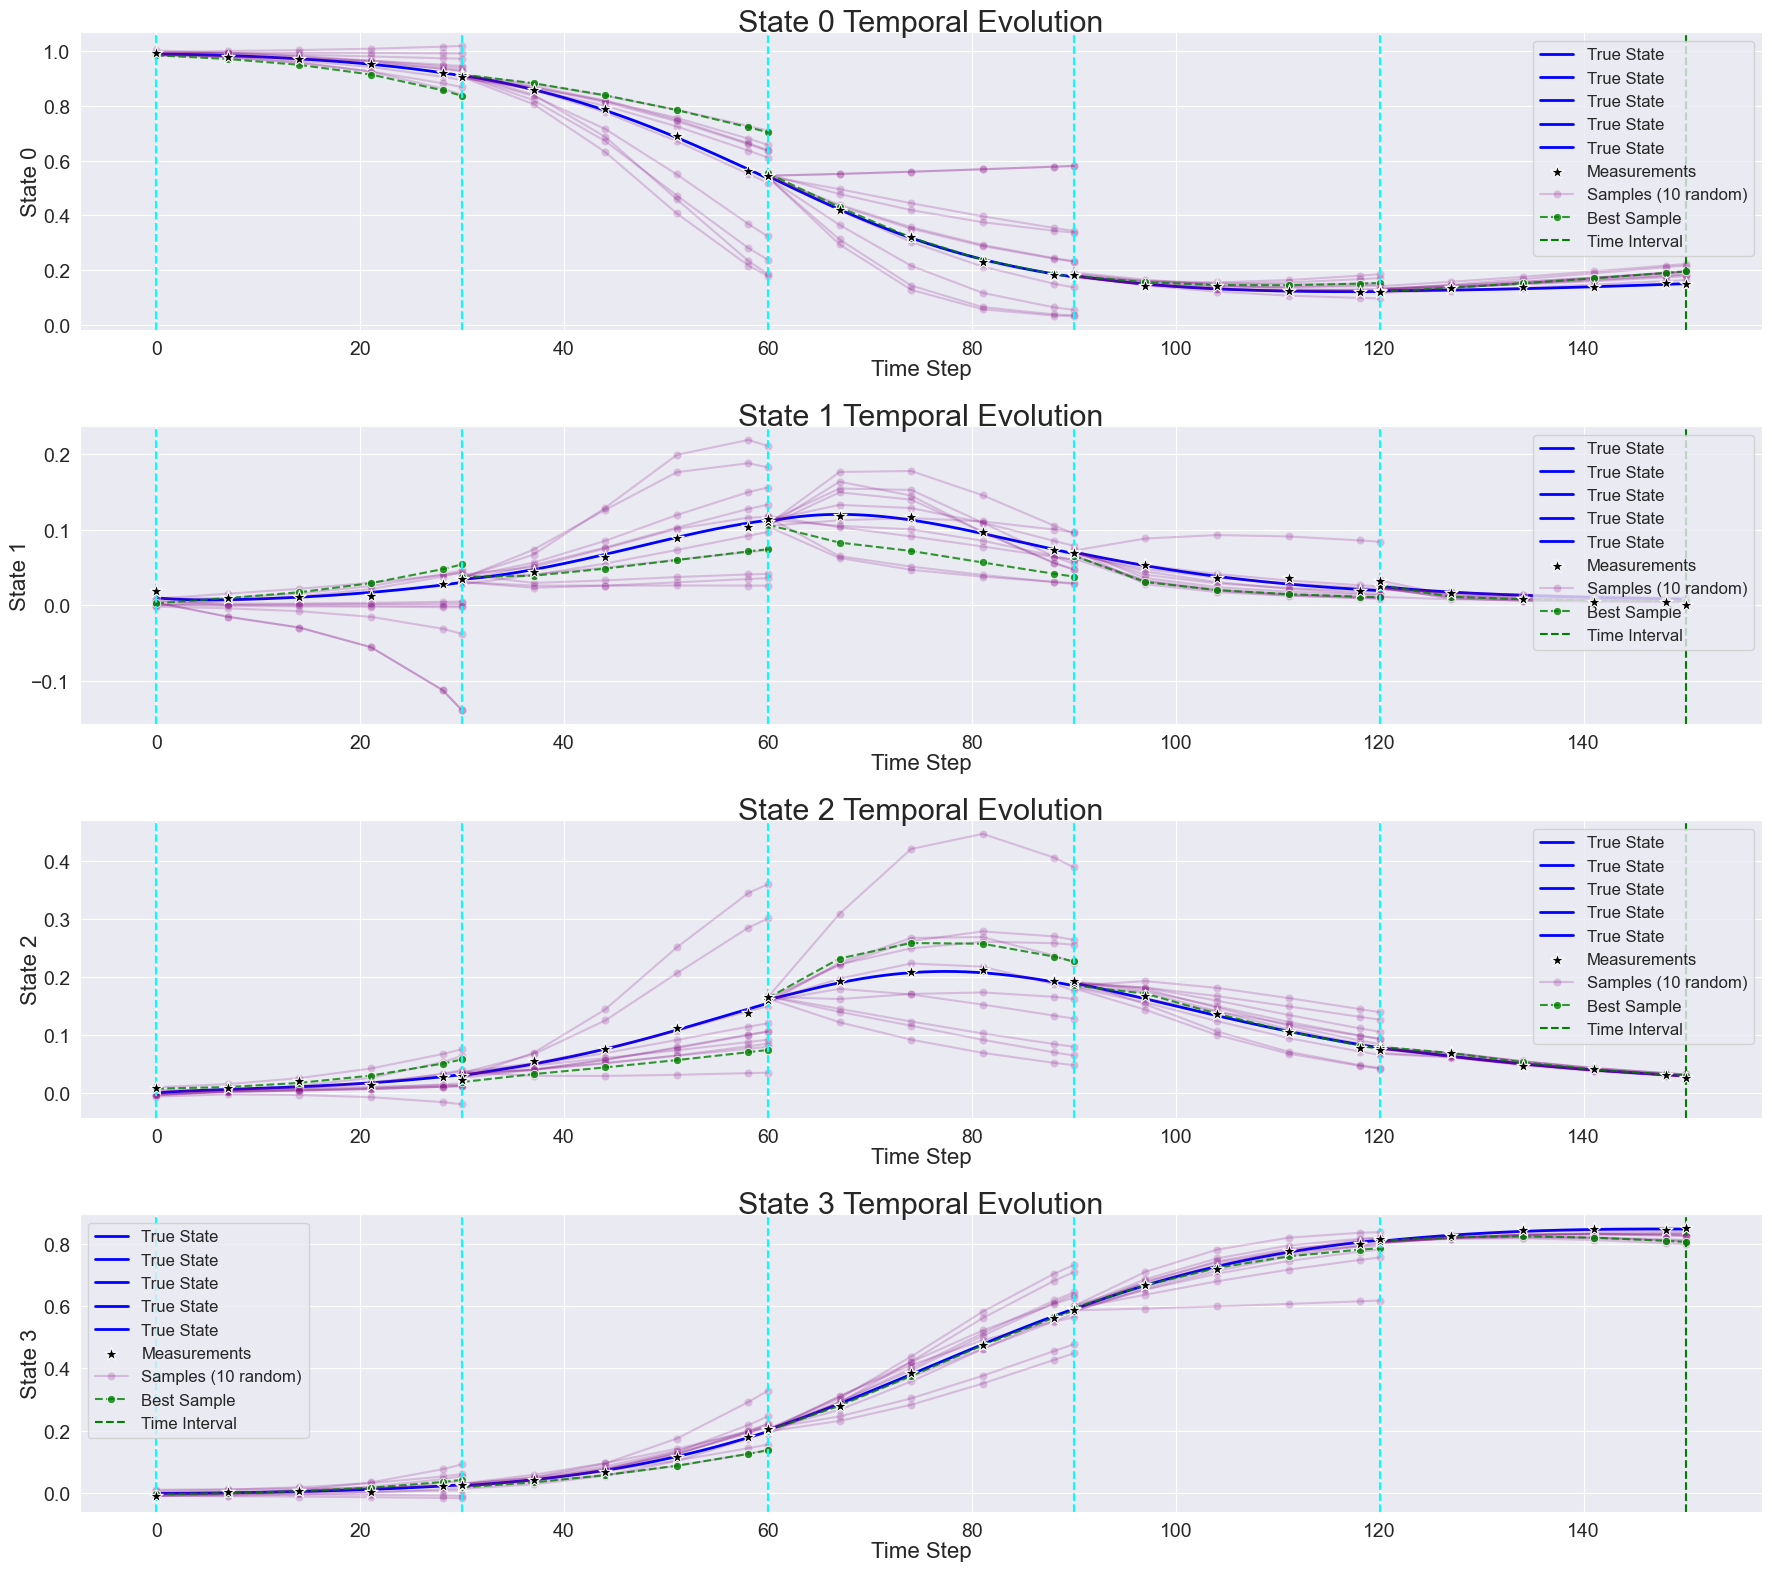

In [ ]:
sr.plot_states()

# Old Functions

In [ ]:
from numpy.linalg import LinAlgError
from pydci.log import enable_log, disable_log, logger
from pydci.utils import get_df, add_noise, KDEError, set_seed
from pydci import PCAMUDProblem
import pdb
import numpy as np

def online_iterative(self,
                 num_its=1,
                 max_nc=3,
                 data_chunk_size=7,
                 num_samples=100):
    """
    Online Solve
    """
    search_res = []
    bad_res = []
    scale = 1.0

    if len(self.probs) == 0:
        pi_in, samples = self.get_uniform_initial_samples(
            num_samples=num_samples,
            scale=1.0)
        it = 1
    else:
        pi_in = self.probs[-1].dists['pi_up']
        it = len(self.probs)

    max_its = it + num_its
    best_flag = np.empty((num_samples, 1), dtype=bool)
    while it < max_its:
        if it > len(self.data):
            # logger.info(f"Getting data for iteration {it}")
            self.get_data(it*data_chunk_size)

        self.forward_solve(samples)
        search_combs = self.get_search_combinations(
            max_nc=max_nc,
            data_chunk_size=data_chunk_size
        )
        disable_log()
        res = self.solve_search(
            search_combs,
            exp_thresh=0.1,
            best_method="max_kl",
            pi_in=pi_in
        )
        if res['best'] is None:
            avg_kl = np.mean(res['search_results']['kl'])
            logger.info(f'Suspected shift in params at {it}: KL Divergence: {avg_kl}')
            pi_in, samples = self.get_uniform_initial_samples(num_samples=n_samples, scale=1.0)
            bad_res.append((it, res))
        else:
            # logger.info(f"Best solution found:{res['best'].result}")
            self.probs.append(res['best'])
            best_flag[:] = False
            best_flag[res['best'].mud_arg] = True
            self.samples[-1]["best_flag"] = best_flag
            samples= self.probs[-1].sample_dist(num_samples=num_samples)
            pi_in = self.probs[-1].dists['pi_up']
            it += 1


def adaptive_online_iterative(
    self,
    time_windows,
    diff=0.5,
    num_samples=100,
    nc=1,
    resample_thresh=0.2,
    shift_thresh=0.9,
    min_eff_sample_size=0.5,
    weights=None,
    seed=None,
):
    """
    Online solve

    If problem has not been initialized (no self.probs[] array), then the problem
    is initialized with a uniform distribution over the parameter space around the
    true value, with a scale of `diff` controlling the size of the uniform distribution
    around the true value we search for, and hence the problem difficulty.
    Solve inverse problem for `num_its` consuming `time_step` data at each iteration.
    At each iteration, a set of possible sovle parameters will be searched for, using
    varying number of PCA components, data points, and splits. The best solution will
    be determined by the `best_method` argument.

    """
    logger.debug(f'Running online iterative solve over time window {time_windows}')

    if seed is not None:
        logger.info(f'Setting seed to {seed}')
        set_seed(seed)


    if len(time_windows) < 2:
        raise ValueError("time_windows must be a list of at least length 2")
    time_windows.sort()
    if weights is not None and len(weights) != num_samples:
        raise ValueError(f"weights must be None or of length {num_samples}")


    logger.debug(f'Drawing {num_samples} samples from uniform +- {diff} around true value')
    pi_in, samples = self.get_uniform_initial_samples(
        num_samples=num_samples,
        scale=diff)

    weights = [] if weights is None else weights
    best_flag = np.empty((num_samples, 1), dtype=bool)
    t0 = time_windows[0]
    probs = []
    restart = False 
    sample_groups = []                # List of lists of data chunks groups used by common set of samples
    sample_group = []                 # List for current iteration of data chunks used by common set of samples
    skip_intervals = []               # List of intervals where no solution was found  
    for i, t in enumerate(time_windows[1:]):
        sample_group += [i]
        logger.debug(f"Getting measurements over time window {t0} to {t}")
        self.get_data(t - t0, t0=t0)
        measurements = get_df(self.data[-1].dropna(), 'q_lam_obs', self.n_sensors)

        num_tries = 0
        solution_found = False
        prev_samples = samples
        prev_pi_in = pi_in
        while not solution_found and num_tries < 2:
            # Solve -> Saves states in state dictionary
            self.forward_solve(samples, restart=restart)

            prob = PCAMUDProblem(
                self.samples[-1],
                measurements,
                self.measurement_noise,
                pi_in=pi_in,
            )
            prob.set_weights(weights)

            try:
                prob.solve(pca_components=list(range(nc)))
            except ZeroDivisionError as z:
                # Zero division means predictabiltiy assumption violated
                # -> Param shift may have occured as predicted prob
                #    of a sample was set to zero where observed data was non-zero
                e_r_delta = -1.0
                logger.error(f"Failed: Ill-posed problem: {z}. Suspected param shift.")
            else:
                e_r = prob.result["e_r"].values[0]
                e_r_delta = np.abs(e_r - 1.0)
                logger.info(f"Succesfully solved problem - e_r_delta = {e_r_delta}, kl = {prob.divergence_kl()}")

            # If failed to solve problem because we have refined our weights to much
            # On the current set of samples, then resample from previous iterations updated distribution
            # To start with a fresh set of samples and no weights
            # This occurs when
            #   1. Weights vector is too refined, zero-ing out too many samples so we don't have enough variability
            #       in our samples to solve the problem usinG KDEs -> error through by prob.solve() which we catch by setting e_r_delta = 1.0
            #   2. The e_r_delta we get is above our resampling threshold, but not greater than the shift threshold where we may
            #       think that the true params have shifted and a violation of the predictabiltiy assumption is occuring instead
            #       of jus a resolution issue due to weighting of the curent samples.
            # over-ref
            if (e_r_delta > resample_thresh)  and (e_r_delta < shift_thresh):
                if i == 0:
                    # Won't be able to sample from previous if this is the first iteration
                    raise ValueError("Problem is ill-posed and cannot be solved from the first iteration.")
                logger.info(f"|E(r) - 1| = {e_r_delta} : < 0 or > {resample_thresh} -> Resampling from previous pi_up and retrying.")
                samples = probs[-1].sample_dist(num_samples, dist='pi_up')
                pi_in = probs[-1].dists['pi_up']
                logger.info(f"Zeroing out weights and retrying solve.")
                weights = []
                num_tries += 1
                restart = True
            elif e_r_delta > shift_thresh or e_r_delta < 0.0:
                logger.info(f"|E(r) - 1| = {e_r_delta} > {shift_thresh} --> Shift.")
                logger.info(f"Drawing {num_samples} samples from uniform +- {diff} around true value")
                pi_in, samples = self.get_uniform_initial_samples(num_samples=num_samples, scale=diff)
                weights = []
                num_tries += 1
                restart = True
            else:
                logger.info(f"|E(r) - 1| = {e_r_delta} < {resample_thresh} - Keeping solution.")
                logger.info(f"{prob.result}")
                probs.append(prob)

                best_flag = np.empty((num_samples, 1), dtype=bool)
                best_flag[:] = False
                best_flag[prob.mud_arg] = True
                self.samples[-1]['best_flag'] = best_flag

                solution_found = True
                # Determine if new set of weights is too refined -> Calculate effective sample size
                weights.append(prob.state["ratio"].values)
                net_weights = np.prod(np.array(weights).T, axis=1)
                eff_num_samples = len(np.where(net_weights > 1e-10)[0])
                logger.info(f"Effective sample size: {eff_num_samples}")
                if eff_num_samples/num_samples < min_eff_sample_size:
                    logger.info(f"Getting new set of samples ({eff_num_samples} < {min_eff_sample_size}).")
                    samples = prob.sample_dist(num_samples, dist='pi_up')
                    pi_in = prob.dists['pi_up']
                    weights = []
                    restart = True                              # Whether to restart the forward solve simulations or continue from previous final state.
                    sample_groups.append(sample_group)
                    sample_group = []
                else:
                    if num_tries > 0:
                        # Got here after a retry -> Clear sample groups
                        sample_groups.append(sample_group)
                        sample_group = []
                    logger.info(f"Keeping samples.")
                    restart = False
        
        if not solution_found:
            logger.info(f"No good solution found. Skipping to next time window.")
            pi_in = prev_pi_in
            samples = prev_samples 
            restart = False
            skip_intervals.append(i)
            
        
        logger.info(f'Sample groups {sample_group}')
        t0 = t
    
    return sample_groups, probs

def param_density(probs, param_idx=0, idxs=None, figsize=(5,5), lam_true=None, ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Plot initial at first iteration
    labels = []
    idxs = np.arange(len(probs)) if idxs is None else idxs
    _ = probs[idxs[0]].plot_L(ax=ax,
                    param_idx=param_idx,
                    initial_kwargs={"color": "black", "linestyle": ":", "fill": True},
                    update_kwargs=None,
                    plot_legend=False,
                    mud_kwargs=None,
                    lam_true=None
    )
    labels += [f'$\pi^{{in}}$']
    if len(idxs) > 2:
        alphas = np.linspace(0.1,0.9,len(idxs))
        for i, j in enumerate(idxs[1:-1]):
            _, l = probs[j].plot_L(ax=ax,
                            param_idx=param_idx,
                            initial_kwargs=None,
                            update_kwargs={"color": "blue", "alpha": alphas[i], "linestyle": "--", "fill": False},
                            plot_legend=False,
                            mud_kwargs=None,
                            lam_true=None
            )
            labels += [f'$\pi^{{up}}_{{{j}}}$']
    # plot update at final iteration
    _, l = probs[idxs[-1]].plot_L(ax=ax,
                    param_idx=param_idx,
                    initial_kwargs=None,
                    update_kwargs={"color": "blue", "linestyle": "-", "fill": True},
                    plot_legend=False,
                    mud_kwargs={'color': 'blue'},
                    lam_true=None,
    )
    labels += [f'$\pi^{{up}}$', '$\lambda^{mud}$']
    for l in lam_true:
        if len(l) == 2:
            ax.axvline(
                x=l[1][param_idx],
                linewidth=3,
                color="orange",
            )
            labels += [f'$\lambda^{{\dagger}}_{{{l[0]}}}$']
        else:
            ax.axvline(
                x=l[param_idx],
                linewidth=3,
                color="orange",
            )
            labels += [f'$\lambda^{{\dagger}}$']
    labels += l

    ax.legend(labels)

    return ax

def plot_iterations(probs, idxs=None, figsize=(12,12), lam_true=None):

    fig, axs = plt.subplots(2, 2, figsize=figsize)

    # idxs = np.arange(1, len(probs)-1, 1 if )
    for i, ax in enumerate(axs.flat):
        param_density(probs, param_idx=i, idxs=idxs, ax=ax, lam_true=lam_true)
    
    return axs
# plot_iterations(probs, idxs=np.arange(0, 10, 2), lam_true=[SEIRS_P2])


def plot_iterations_old(probs, idxs=None, figsize=(9,9), lam_true=None):

    fig, axs = plt.subplots(2, 2, figsize=figsize)

    for i, ax in enumerate(axs.flat):
        # Plot initial at first iteration
        probs[0].plot_L(iteration=0,
                        ax=ax,
                        param_idx=i,
                        initial_kwargs={"color": "black", "linestyle": ":", "fill": False},
                        update_kwargs=None,
                        plot_legend=False,
                        mud_kwargs=None,
                        lam_true=None
        )
        # Plot update at final iteration
        probs[-1].plot_L(iteration=-1,
                        ax=ax,
                        param_idx=i,
                        initial_kwargs=None,
                        update_kwargs={"color": "blue", "linestyle": "-", "fill": False},
                        plot_legend=False,
                        mud_kwargs={'color': 'blue'},
                        lam_true=lam_true,
        )